# Preamble

This is an IPython Notebook to accompany the paper entitled 'The Architecture of Genome Wide Association Studies' by Melinda Mills and Charles Rahal. This allows us to share data analysis done in the construction of this data-driven review of all GWAS to date. It can also be used to dynamically replicate the analysis herein going forward. For installation guidelines, please see the readme.md which accompanies this repository. A preliminary point to note is that if you wish to run this .ipynb file itself, you *may* need to override the default settings of some versions of Jupyter Notebook (4.2 to 5.1) by opening with:

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
```
or editing your jupyter_notebook_config.py file. Lets begin by loading in our favourite python modules, ipython magic and a bunch of custom functions we've written specifically for this project:

In [1]:
import networkx as nx
import os
import pandas as pd
import re
import requests
import seaborn as sns
import sys
import numpy as np
import csv
import itertools
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from matplotlib import rc

import gender_guesser.detector as gender
from Bio import Entrez
from PIL import Image
import requests_ftp

from wordcloud import WordCloud, STOPWORDS
from IPython.display import HTML, display

from Support.LoadData import (
    EFO_parent_mapper, load_gwas_cat, load_pubmed_data, 
    make_timely, make_clean_CoR
)
from Support.PubMed import (
    build_collective, build_author, build_funder,
    build_abstract, build_citation
)
from Support.Ancestry import ancestry_cleaner
from Support.Additional import (grey_color_func, clean_names)

warnings.filterwarnings('ignore')
mpl.rcParams.update(mpl.rcParamsDefault)
%config InlineBackend.figure_format = 'png'
%matplotlib inline
%load_ext autoreload
%autoreload 2

Then, let's dynamically grab the three main curated datasets from the GWAS Catalogue [EBI website](https://www.ebi.ac.uk) that we will need for our endeavours ('All Associations','All Studies', 'All Ancestries') and the EFO to Parent trait mapping file from their FTP site:

In [2]:
r = requests.get(
    'https://www.ebi.ac.uk/gwas/api/search/downloads/studies_alternative')
with open(os.path.abspath(
          os.path.join('__file__', '../..', 'Data', 'Catalogue', 'Raw',
                       'Cat_Stud.tsv')), 'wb') as tsvfile:
        tsvfile.write(r.content)
r = requests.get(
    'https://www.ebi.ac.uk/gwas/api/search/downloads/ancestry')
with open(os.path.abspath(
          os.path.join('__file__', '../..', 'Data', 'Catalogue', 'Raw',
                       'Cat_Anc.tsv')), 'wb') as tsvfile:
    tsvfile.write(r.content)
r = requests.get('https://www.ebi.ac.uk/gwas/api/search/downloads/full')
with open(os.path.abspath(
          os.path.join('__file__', '../..', 'Data', 'Catalogue', 'Raw',
                       'Cat_Full.tsv')), 'wb') as tsvfile:
    tsvfile.write(r.content)
requests_ftp.monkeypatch_session()
s = requests.Session()
ftpsite = 'ftp://ftp.ebi.ac.uk/'
subdom = '/pub/databases/gwas/releases/latest/'
file = 'gwas-efo-trait-mappings.tsv'
r = s.get(ftpsite+subdom+file)
with open(os.path.abspath(
          os.path.join('__file__', '../..', 'Data',
                       'Catalogue', 'Raw', 'Cat_Map.tsv')),
          'wb') as tsvfile:
   tsvfile.write(r.content)

Lets link the PUBMEDID variable to the PUBMED API and get a series of datasets from that using the support functions written in PubMed.py. Note: *collective* corresponds mostly consortia and study groups.

In [3]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
id_list = set(Cat_Studies['PUBMEDID'].astype(str).tolist())
Entrez.email = 'your.email@goeshere.com'
papers = Entrez.read(Entrez.efetch(db='pubmed',
                     retmode='xml', id=','.join(id_list)))
build_collective(papers)
build_author(papers)
build_funder(papers)
build_abstract(papers)
build_citation(id_list,Entrez.email)

# Introduction

## Some simple 'facts'

Lets do some basic descriptive analysis to see what we've got here:

In [4]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()

print('There are currently: ' + str(len(Cat_Studies['PUBMEDID'].unique())) +
      ' GWAS papers published (in terms of unique PUBMEDIDs)')
print('The first observed GWAS in the catalogue was dated: ' +
      str(Cat_Studies['DATE'].min()))
print('However, only: ' + str(len(Cat_Studies[Cat_Studies['DATE'].str.contains(
    '2005|2006')])) + ' papers were published in 2005 and 2006 combined')
print('There are currently: ' +
      str(len(Cat_Studies['STUDY ACCESSION'].unique())) +
      ' unique Study Accessions')
print('There are currently: ' +
      str(len(Cat_Studies['DISEASE/TRAIT'].unique())) +
      ' unique Diseases/Traits studied')
print('These correspond to: ' +
      str(len(Cat_Studies['MAPPED_TRAIT'].unique())) +
      ' unique EBI "Mapped Traits"')
print('The total number of Associations found is currently: ' +
      str(round(Cat_Studies['ASSOCIATION COUNT'].sum(), 1)))
print('The average number of Associations is currently: ' +
      str(round(Cat_Studies['ASSOCIATION COUNT'].mean(), 1)))
print('Mean P-Value for the strongest SNP risk allele is currently: ' +
      str(round(Cat_Full['P-VALUE'].astype(float).mean(), 10)))
print('The number of associations reaching the 5e-8 threshold is ' +
      str(len(Cat_Full[Cat_Full['P-VALUE'].astype(float) < 5.000000e-8])))
print('The journal to feature the most GWAS studies since ' +
      str(Cat_Studies['DATE'].min()) +
      ' is: ' + Cat_Studies['JOURNAL'].mode()[0])
print('However, in 2017, ' + Cat_Studies[Cat_Studies['DATE'].str.contains(
    '2017')]['JOURNAL'].mode()[0] +
    ' published the largest number of GWAS papers')
print('Largest Accession to date: ' +
      str(Cat_Ancestry_groupedbyN.sort_values(by='N',
                                              ascending=False)['N'].iloc[0]) +
      ' people.\nThis was published in ' +
      str(Cat_Studies[
          Cat_Studies['STUDY ACCESSION'] ==
          Cat_Ancestry_groupedbyN.sort_values(by='N',
                                              ascending=False)
          ['STUDY ACCESSION'].iloc[0]]['JOURNAL'].iloc[0]) +
      '.\nThe first author was: ' +
      str(Cat_Studies[
          Cat_Studies['STUDY ACCESSION'] ==
          Cat_Ancestry_groupedbyN.sort_values(by='N',
                                              ascending=False)
          ['STUDY ACCESSION'].iloc[0]]
          ['FIRST AUTHOR'].iloc[0]) + '.')
print('Total number of SNP-trait associations is ' +
      str(Cat_Studies['ASSOCIATION COUNT'].sum()) + '.')
print('Total number of journals publishing GWAS is ' +
      str(len(Cat_Studies['JOURNAL'].unique())) + '.')
print('The study with the largest number of authors has: ' +
      str(AuthorMaster.groupby(['PUBMEDID'])['AUTHORNAME'].count().max()) +
      ' authors.')

There are currently: 3314 GWAS papers published (in terms of unique PUBMEDIDs)
The first observed GWAS in the catalogue was dated: 2005-03-10
However, only: 10 papers were published in 2005 and 2006 combined
There are currently: 4943 unique Study Accessions
There are currently: 2909 unique Diseases/Traits studied
These correspond to: 2191 unique EBI "Mapped Traits"
The total number of Associations found is currently: 67230
The average number of Associations is currently: 13.6
Mean P-Value for the strongest SNP risk allele is currently: 1.5748e-06
The number of associations reaching the 5e-8 threshold is 33026
The journal to feature the most GWAS studies since 2005-03-10 is: Nat Genet
However, in 2017, Nat Commun published the largest number of GWAS papers
Largest Accession to date: 616919.0 people.
This was published in J Clin Endocrinol Metab.
The first author was: Hu Y.
Total number of SNP-trait associations is 67230.
Total number of journals publishing GWAS is 436.
The study with th

## Can the abstracts give us any clues?

Lets make a nice infographic and do some basic NLP on the abstracts from all PUBMED IDs. This figure is the header on the readme.md:

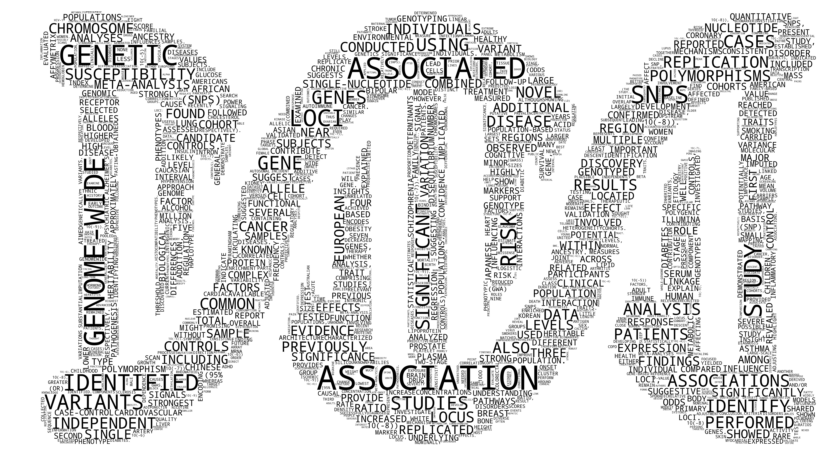

In [5]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
words_array = []
with open(os.path.abspath(
          os.path.join('__file__', '../..', 'Data', 'PUBMED',
                       'Pubmed_AbstractCount.csv')),
          'r', errors='replace') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['word'].lower() not in STOPWORDS:
            if len(row['word']) > 3:
                words_array.append(
                    (row['word'].upper(), float(row['num_words'])))
mask = Image.new('RGBA', (8000, 4467))
icon = Image.open(os.path.abspath(
                  os.path.join('__file__', '../..', 'Data', 'Support',
                               'doublehelix_mask.png'))).convert('RGBA')
mask.paste(icon, icon)
mask = np.array(mask)
wc = WordCloud(background_color='white', max_words=1250, mask=mask,
               max_font_size=5000)
wc.generate_from_frequencies(dict(words_array))
wc.recolor(color_func=grey_color_func)
wc.to_file(os.path.abspath(
           os.path.join('__file__', '../../', 'Figures', 'pdf',
                        'helix_wordcloud_1250_5000_black.pdf')))
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The file Pubmed_AbstractCount in PUBMED (subdirectory of Data) details a breakdown of the abstract counts. Check counts for 'European', 'Asian', etc.

# The growth in depth and scope of GWAS over time

We can also visualise the ever increasing sample sizes and the popularity of GWAS. The top panel shows the increasing number of GWAS conducted over time. We also see increasingly large sample sizes: i.e. the fraction of 'Big N' sample size studies increases. The bottom left subplot shows that with this growth comes bigger N and a high correlatation with the number of significant Associations found. The right subplot shows the unique number of journals publishing GWAS per year and the unique number of diseases or traits studied. Both steadily increase as the appeal of GWASs broadens.

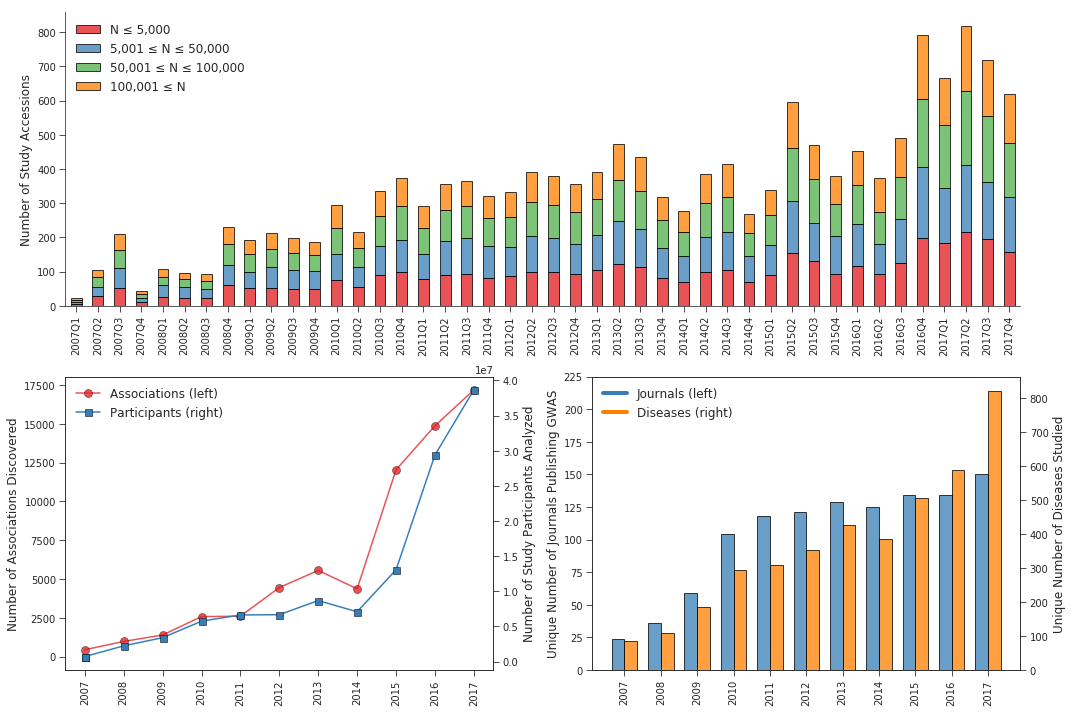

In [6]:
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['axes.linewidth'] = 0.75
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
yearlist = []
yearquarterlist = []
for year in range(2007, 2018):
    yearlist.append(str(year))
    for quarter in ['Q1', 'Q2', 'Q3', 'Q4']:
        yearquarterlist.append(str(year) + quarter)
variables = ['N ≤ 5,000', '5,001 ≤ N ≤ 50,000', '50,001 ≤ N ≤ 100,000',
             '100,001 ≤ N', 'N', 'Associations', 'Journals Printing GWAS',
             '# Diseases Studied']
df_years, df_quarters = make_timely(variables, yearlist, yearquarterlist,
                                    Cat_Studies, Cat_Ancestry,
                                    Cat_Ancestry_groupedbyN)
plt.figure(figsize=(15, 10))
axA = plt.subplot(2, 1, 1)
ax0variables = ['N ≤ 5,000', '5,001 ≤ N ≤ 50,000',
                '50,001 ≤ N ≤ 100,000', '100,001 ≤ N']
ax0 = df_quarters[ax0variables].plot(kind='bar', stacked=True, ax=axA,
                                     color=['#e41a1c', '#377eb8',
                                            '#4daf4a', '#ff7f00'],
                                     alpha=0.75, edgecolor='k')
sns.despine(top=True, right=True, ax=ax0)
ax0.set_ylabel('Number of Study Accessions', fontsize=12)
ax0.tick_params(labelsize=10)
ax0.legend(fontsize=12, loc='upper left')
#ax0.grid(b=True, which='major', color='#d3d3d3', linestyle='--', alpha=0.75)
axB = plt.subplot(2, 2, 3)
ax1a = df_years[['Associations']].plot(ax=axB, color='#e41a1c', alpha=0.75,
                                       rot=90, marker='o', linewidth=1.5,
                                       markersize=8,
                                       label='Associations Discovered',
                                       markeredgecolor='k',
                                       markeredgewidth=0.5)
ax1b = axB.twinx()
ax1b.plot(df_years[['N']], color='#377eb8', marker='s', markersize=7,
          linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
ax1a.set_ylabel('Number of Associations Discovered', fontsize=12)
ax1b.set_ylabel('Number of Study Participants Analyzed', fontsize=12)
ax1b.grid(False)
axB.plot(0, 0, '-r', color='#377eb8', marker='s', markersize=7,
         markeredgecolor='k', markeredgewidth=0.5)
axB.legend(['Associations (left)', 'Participants (right)'],
           fontsize=12, loc='upper left')
ax1a.tick_params(labelsize=10)
ax1b.tick_params(labelsize=10)
#axB.grid(b=True, which='major', color='#d3d3d3', linestyle='--', alpha=0.75)
plt.axis('tight')

axC = plt.subplot(2, 2, 4)
axtest = axC.twinx()
ax_2a = df_years[['Journals Printing GWAS']].plot(kind='bar',
                                                  ax=axC, position=1,
                                                  color='#377eb8',
                                                  legend=False, width=0.35,
                                                  alpha=0.75, edgecolor='k')
ax_2b = df_years[['# Diseases Studied']].plot(kind='bar', ax=axtest,
                                              position=0, color= '#ff7f00',
                                              width=0.35, legend=False,
                                              alpha=0.75, edgecolor='k')
ax_2a.set_ylabel('Unique Number of Journals Publishing GWAS', fontsize=12)
ax_2b.set_ylabel('Unique Number of Diseases Studied', fontsize=12)
ax_2b.grid(False)
axC.plot(np.nan, '#377eb8', linewidth=4)
axC.plot(np.nan, '#ff7f00', linewidth=4)
axC.legend(['Journals (left)', 'Diseases (right)'],
           fontsize=12, loc='upper left')
ax_2a.margins(1, 0.5)
ax_2a.tick_params(labelsize=10)
ax_2b.tick_params(labelsize=10)
#axC.grid(b=True, which='major', color='#d3d3d3', linestyle='--', alpha=0.75)
plt.axis('tight')
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.tight_layout()

plt.savefig(os.path.abspath(os.path.join('__file__', '../..',
                                         'Figures', 'svg',
                                         'GWAS_Popularity.svg')),
            bbox_inches='tight')
plt.savefig(os.path.abspath(os.path.join('__file__', '../..',
                                         'Figures', 'pdf',
                                         'GWAS_Popularity.pdf')),
            bbox_inches='tight')

#  Participants

## Ancestry

This section of analysis *only* uses data contained within the catalogue, but is slightly deeper than Section 2 above and other related papers in the literature. We use the 'Broad Ancestral Category' field and aggregate from 135 combinations of 17 ancestries to 7 'broader ancestral categories' to calculate a comparable measure to Popejoy and Fullerton. To get a more detailed analysis of polyvocality, we load in some of our supporting functions to clean up the "INITIAL SAMPLE SIZE" and "REPLICATION SAMPLE SIZE" free-text fields in the catalogue and then calculate something analogous to Panofsky and Bliss. The supporting functions are based on regular expression and data wrangling techniques which exploit patterns in the these free-text fields. By way of a very simple example: “19,546 British ancestry individuals from 6863 families.” will get cleaned to two seperate fields: “19,546” and “British” which can then be used for further downstream analysis. A slightly more complex example: “2,798 European ancestry individuals, 228 French Canadian founder population individuals” will correspond to two entries of 2798 and 228 in the new ‘Cleaned N’ type variable, corresponding to ‘European’ and ‘French Canadian’ in the ‘Cleaned Ancestry’ type variable respectively. Uncomment the appropriate lines of text to get the full lists.

In [7]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
Cat_Ancestry['Broader'] = Cat_Ancestry['Broader'].str.replace("/","\\")    
Cat_Studies['InitialClean'] = Cat_Studies.apply(
    lambda row: ancestry_cleaner(row, 'INITIAL SAMPLE SIZE'), axis=1)
Cat_Studies['ReplicationClean'] = Cat_Studies.apply(
    lambda row: ancestry_cleaner(row, 'REPLICATION SAMPLE SIZE'), axis=1)
fileout = open(os.path.abspath(
               os.path.join('__file__', '../..', 'Data',
                            'Catalogue', 'Synthetic',
                            'new_initial_sample.csv')),
               'w', encoding='utf-8')
fileout.write('STUDY ACCESSION,Cleaned Ancestry,Cleaned Ancestry Size\n')
for index, row in Cat_Studies.iterrows():
    checksum = 0
    for ancestry in row['InitialClean'].split(';'):
        number = re.findall(r'\d+', ancestry.strip())
        if (len(number) == 1):
            checksum += 1
    if checksum == len(row['InitialClean'].split(';')):
        for ancestry in row['InitialClean'].split(';'):
            number = re.findall(r'\d+', ancestry.strip())
            words = ''.join(i for i in ancestry.strip() if not i.isdigit())
            if (len(number) == 1) and (len(words.strip()) > 3) and \
               (sum(1 for c in words if c.isupper()) > 0):
                fileout.write(row['STUDY ACCESSION'] + ',' +
                              words.strip() + ',' + str(number[0]) + '\n')
fileout.close()
fileout = open(os.path.abspath(os.path.join('__file__', '../..', 'Data',
                                            'Catalogue', 'Synthetic',
                                            'new_replication_sample.csv')),
               'w', encoding='utf-8')
fileout.write('STUDY ACCESSION,Cleaned Ancestry,Cleaned Ancestry Size\n')
for index, row in Cat_Studies.iterrows():
    checksum = 0
    for ancestry in row['ReplicationClean'].split(';'):
        number = re.findall(r'\d+', ancestry.strip())
        if (len(number) == 1):
            checksum += 1
    if checksum == len(row['ReplicationClean'].split(';')):
        for ancestry in row['ReplicationClean'].split(';'):
            number = re.findall(r'\d+', ancestry.strip())
            words = ''.join(i for i in ancestry.strip() if not i.isdigit())
            if (len(number) == 1) and (len(words.strip()) > 3) and \
               (sum(1 for c in words if c.isupper()) > 0):
                fileout.write(row['STUDY ACCESSION'] + ',' +
                              words.strip() + ',' + str(number[0]) + '\n')
fileout.close()

clean_intial = pd.read_csv(os.path.abspath(
                           os.path.join('__file__', '../..', 'Data',
                                        'Catalogue', 'Synthetic',
                                        'new_initial_sample.csv')),
                           encoding='utf-8')
clean_initial_sum = pd.DataFrame(
    clean_intial.groupby(['Cleaned Ancestry']).sum())
clean_initial_sum.rename(
    columns={'Cleaned Ancestry Size': 'Ancestry Sum', }, inplace=True)
clean_initial_count = clean_intial.groupby(['Cleaned Ancestry']).count()
clean_initial_count.rename(
    columns={'Cleaned Ancestry Size': 'Ancestry Count', }, inplace=True)
clean_initial_merged = clean_initial_sum.merge(pd.DataFrame(
    clean_initial_count['Ancestry Count']), how='outer', left_index=True,
    right_index=True)
clean_initial_merged = clean_initial_merged.sort_values(
    by='Ancestry Sum', ascending=False)
holder = ''
for index, row in clean_initial_merged.iterrows():
    holder = holder + \
        str(index) + ' (' + str(row['Ancestry Sum']) + \
        ',' + str(row['Ancestry Count']) + '), '
print('There are a total of ' + str(len(clean_initial_merged)) +
      ' ancestries found in the \'INITIAL SAMPLE SIZE\' column.')# +
      #'\nThese are: (number of people used used in all studies, ' +
      #'number of studies included):\n\n' + holder[:-2] + '.\n\n')

clean_replication = pd.read_csv(os.path.abspath(
                                os.path.join('__file__', '../..', 'Data',
                                             'Catalogue', 'Synthetic',
                                             'new_replication_sample.csv')),
                                encoding='utf-8')
clean_replication_sum = pd.DataFrame(
    clean_replication.groupby(['Cleaned Ancestry']).sum())
clean_replication_sum.rename(
    columns={'Cleaned Ancestry Size': 'Ancestry Sum', }, inplace=True)
clean_replication_count = clean_replication.groupby(
    ['Cleaned Ancestry']).count()
clean_replication_count.rename(
    columns={'Cleaned Ancestry Size': 'Ancestry Count', }, inplace=True)
clean_replication_merged = clean_replication_sum.merge(
    pd.DataFrame(clean_replication_count['Ancestry Count']),
    how='outer', left_index=True, right_index=True)
clean_replication_merged = clean_replication_merged.sort_values(
    by='Ancestry Sum', ascending=False)
holder = ''
for index, row in clean_replication_merged.iterrows():
    holder = holder + \
        str(index) + ' (' + str(row['Ancestry Sum']) + \
        ',' + str(row['Ancestry Count']) + '), '
print('There are a total of ' + str(len(clean_replication_merged)) +
      ' ancestries found in the \'REPLICATION SAMPLE SIZE\' column.')# +
      #' These are (number of people used used in all studies, number of' +
      #' studies included):\n\n' + holder[:-2] + '.')


There are a total of 207 ancestries found in the 'INITIAL SAMPLE SIZE' column.
There are a total of 147 ancestries found in the 'REPLICATION SAMPLE SIZE' column.


Lets put this number into tables to get a deeper understanding, first including a row which has at least one ancestry as NR, and then dropping all rows in which at least one recorded ancestry is NR:

In [8]:
Broad_Ancestral_Full_initial = pd.DataFrame(
    Cat_Ancestry[Cat_Ancestry.STAGE ==
                 'initial'].groupby(['Broader'])['N'].sum())
Broad_Ancestral_Full_initial.rename(
    columns={'N': 'N (Initial)'}, inplace=True)
Broad_Ancestral_Full_replication = pd.DataFrame(
    Cat_Ancestry[Cat_Ancestry.STAGE ==
                 'replication'].groupby(['Broader'])['N'].sum())
Broad_Ancestral_Full_replication.rename(
    columns={'N': 'N (Replication)'}, inplace=True)
Broad_Ancestral_Full = pd.merge(Broad_Ancestral_Full_initial,
                                Broad_Ancestral_Full_replication,
                                left_index=True, right_index=True)
Broad_Ancestral_Full['Total'] = Broad_Ancestral_Full['N (Initial)'] + \
    Broad_Ancestral_Full['N (Replication)']
Broad_Ancestral_Full['% Discovery'] = (
    Broad_Ancestral_Full['N (Initial)'] /
    Broad_Ancestral_Full['N (Initial)'].sum()) * 100
Broad_Ancestral_Full['% Replication'] = (
    Broad_Ancestral_Full['N (Replication)'] /
    Broad_Ancestral_Full['N (Replication)'].sum()) * 100
Broad_Ancestral_Full['% Total'] = (Broad_Ancestral_Full['Total'] /
                                   Broad_Ancestral_Full['Total'].sum()) * 100
Broad_Ancestral_Full.to_csv(os.path.abspath(
                            os.path.join('__file__', '../..', 'Tables',
                                         'Broad_Ancestral_Full.csv')))
Broad_Ancestral_Full.head(10)

N (Initial)  N (Replication)       Total  \
Broader                                                             
African                     265815.0         126152.0    391967.0   
African Am.\Caribbean      1638329.0         830852.0   2469181.0   
Asian                      4810303.0        5429344.0  10239647.0   
European                  69268220.0       27991188.0  97259408.0   
Hispanic\Latin American    1194851.0         378374.0   1573225.0   
In Part Not Recorded       5467497.0        4681857.0  10149354.0   
Other\Mixed                 483380.0         832069.0   1315449.0   

                         % Discovery  % Replication    % Total  
Broader                                                         
African                     0.319764       0.313267   0.317644  
African Am.\Caribbean       1.970842       2.063212   2.000986  
Asian                       5.786594      13.482409   8.298050  
European                   83.326786      69.509069  78.817506  
Hispanic\Latin American     1.437356       0.939597   1.274917  
In Part Not Recorded        6.577171      11.626213   8.224878  
Other\Mixed                 0.581486       2.066234   1.066019

Drop the 'in part not recorded' rows (i.e. where the Broad Ancestral Category contains at least one NR):

In [9]:
Broad_Ancestral_NoNR = Broad_Ancestral_Full[['N (Initial)',
                                             'N (Replication)',
                                             'Total']]
Broad_Ancestral_NoNR = Broad_Ancestral_NoNR.drop('In Part Not Recorded')
Broad_Ancestral_NoNR['Total'] = Broad_Ancestral_NoNR['N (Initial)'] + \
    Broad_Ancestral_NoNR['N (Replication)']
Broad_Ancestral_NoNR['% Discovery'] = (
    Broad_Ancestral_NoNR['N (Initial)'] /
    Broad_Ancestral_NoNR['N (Initial)'].sum()) * 100
Broad_Ancestral_NoNR['% Replication'] = (
    Broad_Ancestral_NoNR['N (Replication)'] /
    Broad_Ancestral_NoNR['N (Replication)'].sum()) * 100
Broad_Ancestral_NoNR['% Total'] = (Broad_Ancestral_NoNR['Total'] /
                                   Broad_Ancestral_NoNR['Total'].sum()) * 100
Broad_Ancestral_NoNR.to_csv(os.path.abspath(
                            os.path.join('__file__', '../..', 'Tables',
                                         'Broad_Ancestral_NoNR.csv')))
Broad_Ancestral_NoNR.head(10)

N (Initial)  N (Replication)       Total  \
Broader                                                             
African                     265815.0         126152.0    391967.0   
African Am.\Caribbean      1638329.0         830852.0   2469181.0   
Asian                      4810303.0        5429344.0  10239647.0   
European                  69268220.0       27991188.0  97259408.0   
Hispanic\Latin American    1194851.0         378374.0   1573225.0   
Other\Mixed                 483380.0         832069.0   1315449.0   

                         % Discovery  % Replication    % Total  
Broader                                                         
African                     0.342276       0.354479   0.346111  
African Am.\Caribbean       2.109593       2.334642   2.180314  
Asian                       6.193983      15.256118   9.041721  
European                   89.193174      78.653491  85.881124  
Hispanic\Latin American     1.538549       1.063207   1.389175  
Other\Mixed                 0.622424       2.338062   1.161556

Lets now make some bubble plots to visualise the raw broad ancestry field and our fields extracted from the free text strings:

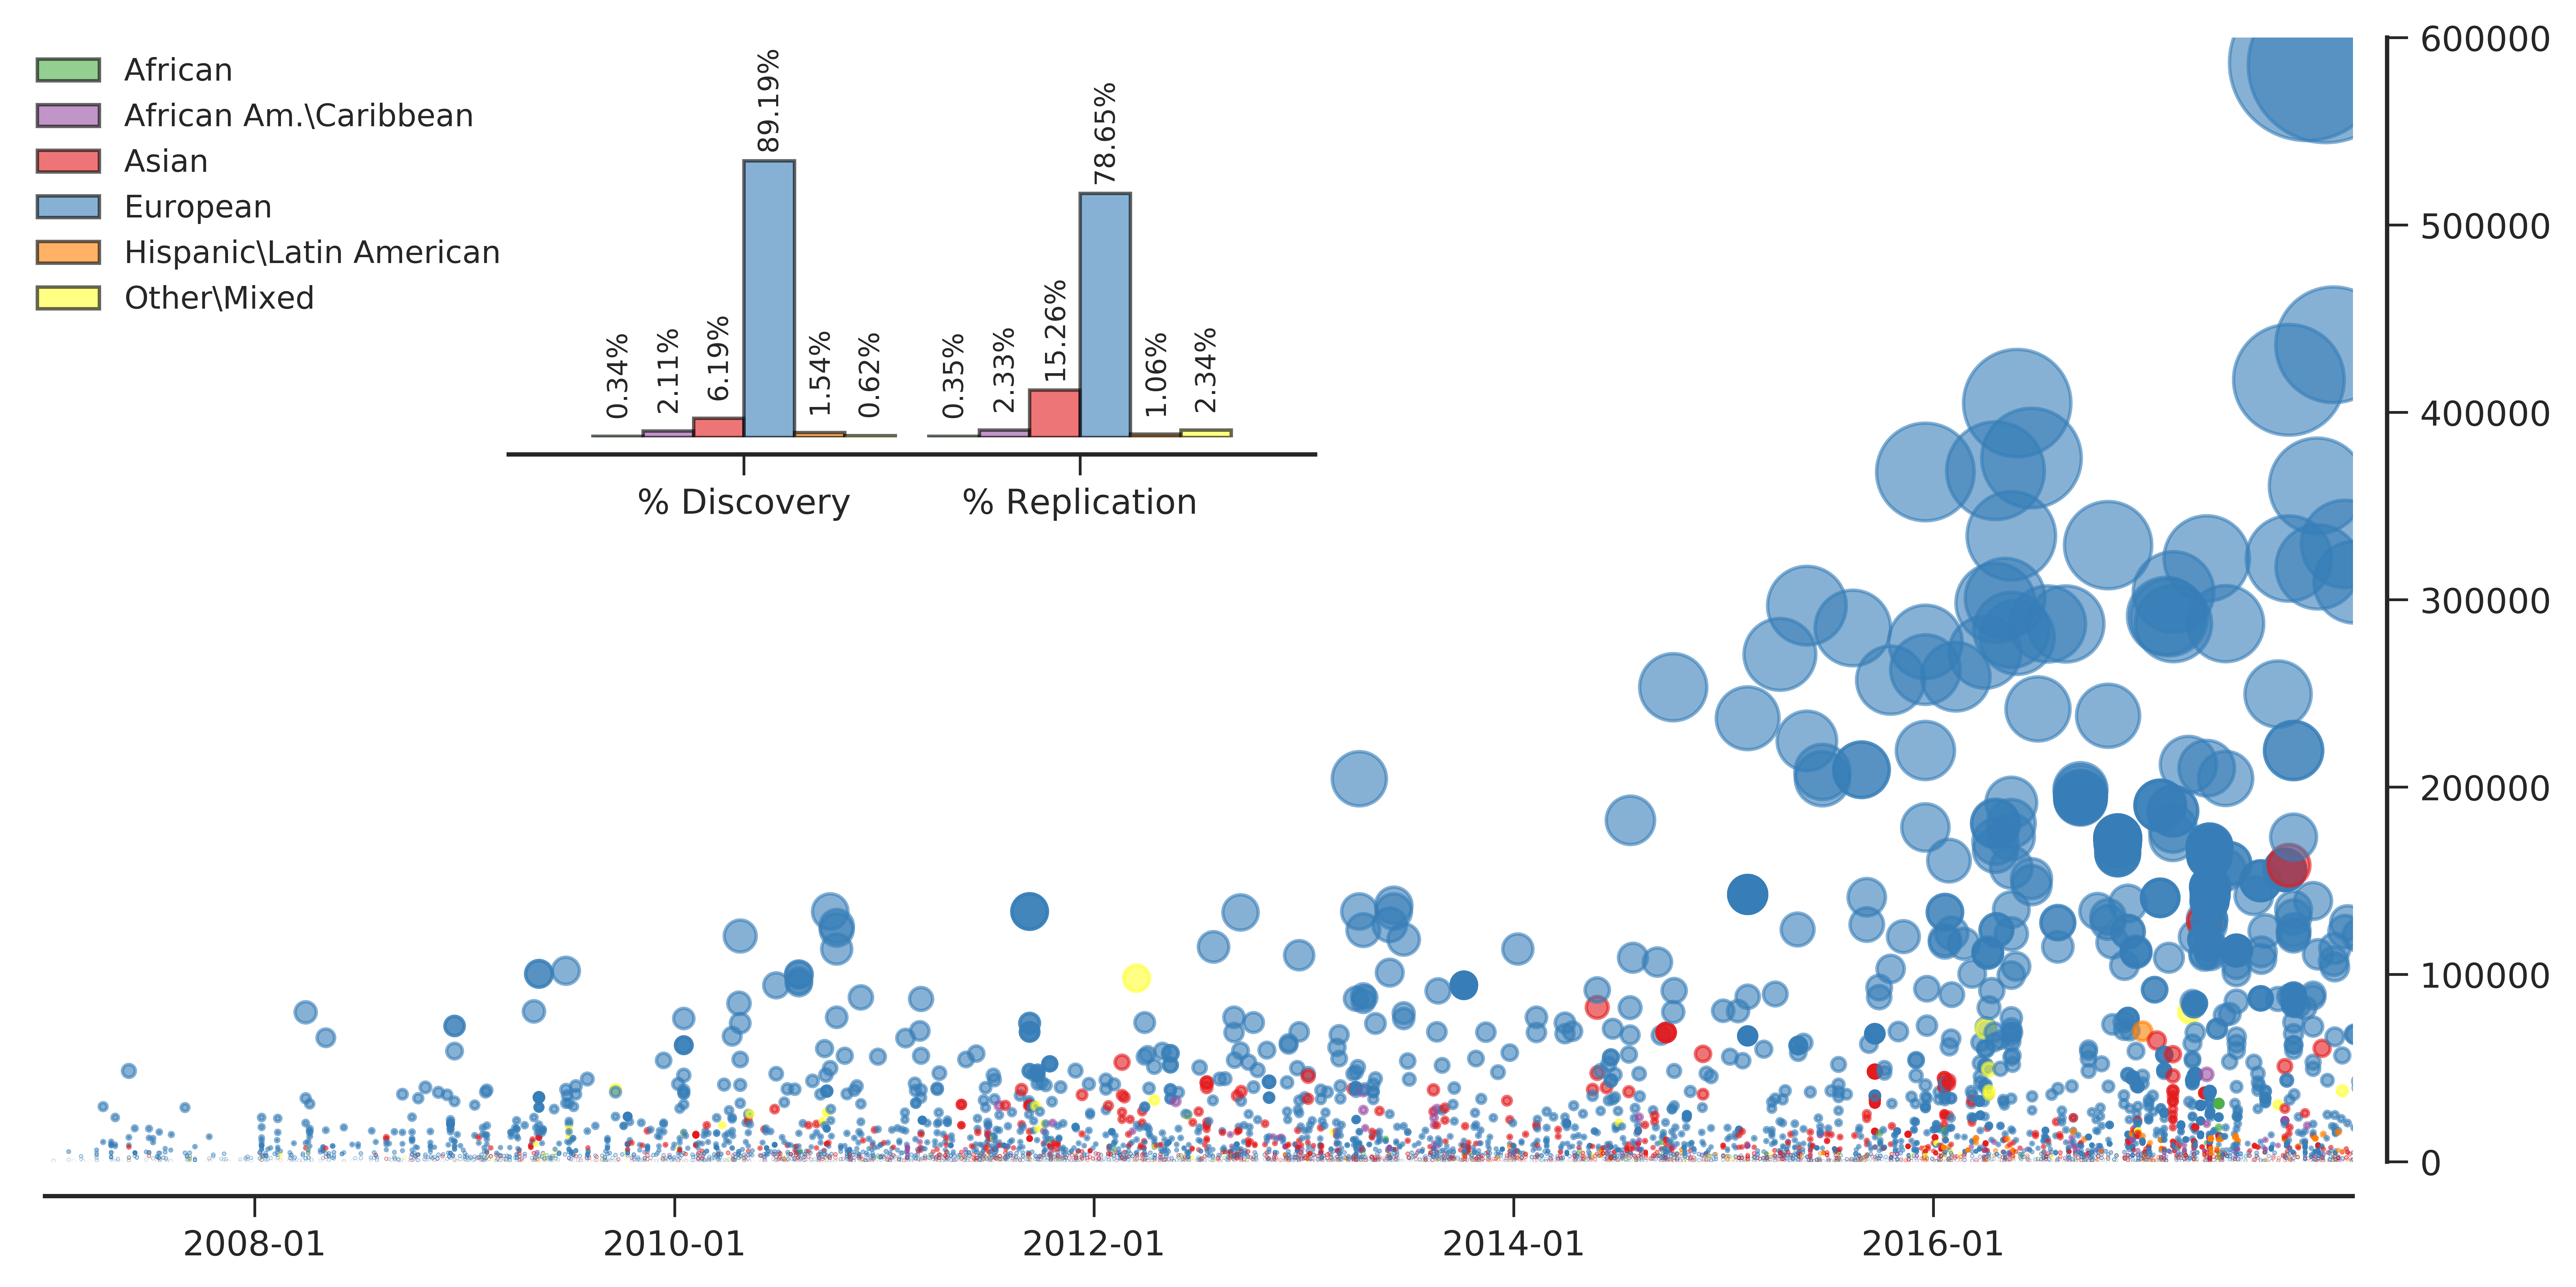

In [10]:
plt.style.use('seaborn-ticks')
plt.rcParams["font.family"] = "Helvetica"

GroupAnc = Cat_Ancestry[(Cat_Ancestry['BROAD ANCESTRAL'] != 'Other') &
                        (Cat_Ancestry['BROAD ANCESTRAL'].str.count(',') == 0)].\
    groupby(['BROAD ANCESTRAL'])['N'].sum().to_frame()
GroupAnc['Individuals (%)'] = (GroupAnc['N'] /
                               GroupAnc['N'].sum()) * 100
GroupAnc = GroupAnc.sort_values(by='Individuals (%)',
                                ascending=False)[0:8]

countriesdict = {'African': '#4daf4a', 'African Am.\Caribbean': '#984ea3',
                 'Asian': '#e41a1c', 'European': '#377eb8',
                 'Hispanic\Latin American': '#ff7f00', 'Other\Mixed': '#ffff33'}

fig = plt.figure(figsize=(12, 6), dpi=800)
ax = fig.add_subplot(1, 1, 1)
for obs in Cat_Ancestry.index:
    for key, value in countriesdict.items():
        if Cat_Ancestry['Broader'][obs].strip() == key:
            ax.plot_date(x=pd.to_datetime(Cat_Ancestry['Dates'][obs]),
                         y=Cat_Ancestry['N'][obs],
                         color=value, marker='.', label='the data',
                         alpha=0.6, markersize=Cat_Ancestry['N'][obs] / 6500)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
ax.set_xlim(pd.Timestamp('2007-01-01'), pd.Timestamp('2017-12-31'))
ax.set_ylim(0, 600000)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
handles, labels = ax.get_legend_handles_labels()

inset_fig = inset_axes(ax, width=3.25,
                       height=1.5, loc=3,
                       bbox_to_anchor=(0.275, .6),
                       bbox_transform=ax.figure.transFigure)
barplot = Broad_Ancestral_NoNR[['% Discovery', '% Replication']].transpose()
barplot = barplot.plot(kind='bar', colors=['#4daf4a','#984ea3',
                                           '#e41a1c','#377eb8',
                                           '#ff7f00','#ffff33'],
                       alpha=0.6, edgecolor='k',linewidth=1,
                       ax=inset_fig, width=0.9)
barplot.set_yticklabels('')
barplot.set_ylabel('')
barplot.set_xlabel('')
barplot.set_ylim(0, 120)
barplot.get_yaxis().set_visible(False)
for p in barplot.patches:
    barplot.annotate(str(round(p.get_height(), 2)) + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height() + 20),
                     ha='center', va='center', rotation=90, fontsize=8)
plt.legend(loc='center right', bbox_to_anchor=(0.025, 0.675), facecolor='white',
           edgecolor='k', frameon=False, prop={'size': 9})

sns.despine(top=True, left=True, right=False, ax=ax, offset=10)
sns.despine(top=True, right=True, left=True, offset=5, ax=inset_fig)

plt.savefig(os.path.abspath(os.path.join('__file__', "../..", "Figures", "svg",
                                         "Ancestral_Plots.svg")),
            bbox_inches='tight')
plt.savefig(os.path.abspath(os.path.join('__file__', "../..", "Figures", "pdf",
                                         "Ancestral_Plots.pdf")),
            bbox_inches='tight')


We can also analyze how these aggregates change over time, and this was a key feature of [Popejoy and Fullerton (2016)](https://www.nature.com/news/genomics-is-failing-on-diversity-1.20759). We can provide a much more granular arguement (merely remove '_NoNR' from the cell below to undertake an equivlent analysis with rows which contain some in part NR ancestries):

In [11]:
index = [x for x in range(2007, 2018)]
columns = ['European', 'Asian', 'African', 'Hispanic\Latin American',
           'Other\Mixed', 'African Am.\Caribbean']
Cat_Ancestry_NoNR = Cat_Ancestry[
    Cat_Ancestry['Broader'] != 'In Part Not Recorded']
Broad_Ancestral_Time_NoNR_PC = pd.DataFrame(index=index, columns=columns)
for year in range(2007, 2018):
    for broaderancestry in Broad_Ancestral_NoNR.index.tolist():
        Broad_Ancestral_Time_NoNR_PC[broaderancestry.strip()][year] =\
            (Cat_Ancestry_NoNR[(
                Cat_Ancestry_NoNR['DATE'].str.contains(str(year))) &
                (Cat_Ancestry_NoNR['Broader'] ==
                 broaderancestry)]['N'].sum() /
             Cat_Ancestry_NoNR[
             (Cat_Ancestry_NoNR['DATE'].str.contains(
                 str(year)))]['N'].sum()) * 100
Broad_Ancestral_Time_NoNR_PC.to_csv(os.path.abspath(
                            os.path.join('__file__', '../..', 'Tables',
                                         'Broad_Ancestral_Time_NoNR_PC.csv')))
Broad_Ancestral_Time_NoNR_PC.head(12)


European    Asian     African Hispanic\Latin American Other\Mixed  \
2007  95.4688  2.13984  0.00542792                0.715245     1.18391   
2008  95.1011  3.06307           0              0.00187221     1.26739   
2009  88.1708  7.10488    0.258137                0.224117     3.36046   
2010  86.5405    10.13    0.273146               0.0596777     2.49373   
2011    78.19  15.8796    0.150837                0.399222     1.71601   
2012  71.1466  20.0446    0.322268                0.910714     2.95966   
2013  81.5499  12.0984      0.4095                0.817999    0.641572   
2014  76.4231  18.7398    0.244282                 1.16827    0.991714   
2015  84.4728  11.8884    0.365494                0.956217     0.65971   
2016  90.9706  4.54435    0.197934                 1.53854     1.29867   
2017  88.1409  6.29419    0.563915                 2.29589    0.518412   

     African Am.\Caribbean  
2007              0.486807  
2008               0.56653  
2009              0.881605  
2010              0.502897  
2011               3.66433  
2012               4.61619  
2013               4.48268  
2014               2.43283  
2015               1.65735  
2016               1.44988  
2017               2.18666

We can focus on the initial discovery stage to calculate the number of individuals required per ancestry to unconver one hit. Note however that this does require some distributional assumptions (i.e. that the same diseases are being studied across ancestries).

In [12]:
Cat_Ancestry_Initial = Cat_Ancestry[Cat_Ancestry['STAGE'] == 'initial']

Cat_Ancestry_NoDups = Cat_Ancestry_Initial.drop_duplicates(
    subset=['STUDY ACCESSION'],
    keep=False)[['PUBMEDID', 'STUDY ACCESSION',
                 'BROAD ANCESTRAL',
                 'N']]
Cat_Ancestry_NoDups_merge = pd.merge(Cat_Ancestry_NoDups,
                                     Cat_Studies[['ASSOCIATION COUNT',
                                                  'STUDY ACCESSION',
                                                  'MAPPED_TRAIT']],
                                     how='left', on='STUDY ACCESSION')

listtoiterate = ['European', 'East Asian', 'South Asian',
                 'African Am.\Caribbean', 'Hispanic\Latin American']
for ancestry in listtoiterate:
    temp = Cat_Ancestry_NoDups_merge[Cat_Ancestry_NoDups_merge[
        'BROAD ANCESTRAL'].str.strip() == ancestry]
    print('The number of ' + ancestry + 's required to find one hit: ' +
          str(round(1 /
                    (temp['ASSOCIATION COUNT'].sum() / temp['N'].sum()), 1)))


The number of Europeans required to find one hit: 1443.7
The number of East Asians required to find one hit: 722.4
The number of South Asians required to find one hit: 616.8
The number of African Am.\Caribbeans required to find one hit: 467.9
The number of Hispanic\Latin Americans required to find one hit: 364.9


## Choropleth map of country of recruitment

This is a choropleth map of country of recruitment - note that this field is not quite fully populated in the Catalogue. Basemap code is loosely based on [this](http://ramiro.org/notebook/basemap-choropleth/). As we want to study the number of people recruited from each country, we can only utilize values in the ‘Country of Recruitment’ field when only one country is mentioned. For example: if N=100,000 and Country of Recruitment = {U.K., U.S.}, there is no way for us to know what the breakdown between the two countries is in the Catalogue (especially as the free text field may just contain 'European' ancestry). Our only option in this scenario is to drop such observations. This forces us to drop about 22% of all the studies, and this corresponds to about 48% of the Catalogue as measured by N (because bigger studies have multiple countries of recruitment). We are faced with multiple entries equal to ‘NR’, which corresponds to ‘not recorded’. This reduces the number of studies to go into the map by a further 21% (of the initial total), and this means that the map only includes about half of all GWAS studies. This has no relationship to whether ancestry is coded.

In [13]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
Clean_CoR = make_clean_CoR(Cat_Ancestry)
Cleaned_CoR_N = pd.DataFrame(Clean_CoR.groupby(['Cleaned Country'])['N'].sum())
Cleaned_CoR_N['Rank_N'] = Cleaned_CoR_N.rank(
    ascending=False, method='dense').astype(int)
Cleaned_CoR_count = pd.DataFrame(
    Clean_CoR.groupby(['Cleaned Country'])['N'].count())
Cleaned_CoR_count['Rank_count'] = Cleaned_CoR_count.rank(
    ascending=False, method='dense').astype(int)
Cleaned_CoR_count = Cleaned_CoR_count.rename(columns={'N': 'Count'})
Cleaned_CoR = pd.merge(Cleaned_CoR_count, Cleaned_CoR_N,
                       left_index=True, right_index=True)
del Cleaned_CoR.index.name
Cleaned_CoR['Percent of Count'] = (Cleaned_CoR['Count'] /
                                   Cleaned_CoR['Count'].sum()) * 100
Cleaned_CoR['Percent of N'] = (Cleaned_CoR['N'] /
                               Cleaned_CoR['N'].sum()) * 100
Cleaned_CoR.sort_values('Rank_N', ascending=True).to_csv(
    os.path.abspath(os.path.join('__file__', '../..', 'Tables',
                                 'CountryOfRecruitment.csv')))
Cleaned_CoR.sort_values('Rank_N', ascending=True)[
    ['Count', 'N', 'Percent of Count', 'Percent of N']].head(10)

Cleaning for single country of recruitment: 72.419%  obs remain. 
This represents about 54.248% of the total GWAS N. 
When we drop for country==NR, we lose another: 23.63% papers.
5384 obs for this field remain out of a total of 9735 rows of Cat_Anc data


Count           N  Percent of Count  Percent of N
United Kingdom    549  15238916.0         10.196880     41.840677
United States    2292   9231811.0         42.570579     25.347290
Iceland            59   3482621.0          1.095840      9.562046
Japan             350   2032401.0          6.500743      5.580255
China             440   1836353.0          8.172363      5.041976
Korea, South      226    730946.0          4.197623      2.006919
Netherlands       160    645945.0          2.971768      1.773537
Finland           134    570202.0          2.488856      1.565573
Germany           164    407208.0          3.046062      1.118049
Australia          98    290948.0          1.820208      0.798840

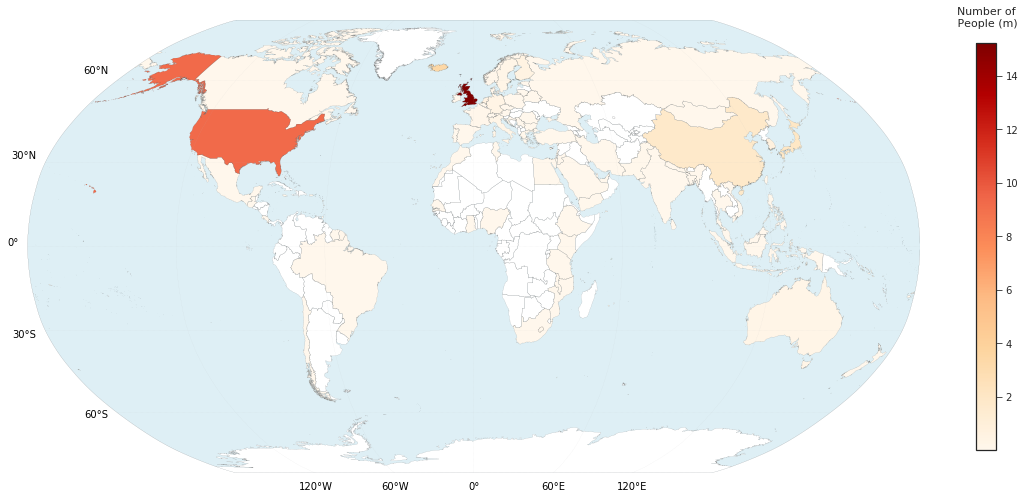

In [14]:
bins = np.linspace(1, len(Cleaned_CoR['Rank_N'].unique()),
                   len(Cleaned_CoR['Rank_N'].unique()))
cm = plt.get_cmap('OrRd')
scheme = [cm(i / 10) for i in range(10)]
Cleaned_CoR['scheme'] = [
    cm(Cleaned_CoR['N'][i] /
       Cleaned_CoR['N'].max()) for i in Cleaned_CoR.index]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, facecolor='#deeff5', frame_on=False)
scheme = [cm(i / len(Cleaned_CoR)) for i in range(len(Cleaned_CoR))]
m = Basemap(lon_0=0, projection='robin', resolution='i')
m.drawmapboundary(color='k', linewidth=0.075)
m.drawcountries(color='k', linewidth=0.025)
m.drawmeridians(np.arange(0, 360, 60), labels=[False, False, False, True],
                color='#bdbdbd', dashes=[6, 6], linewidth=0.1, fontsize=10)
m.drawparallels(np.arange(-90, 90, 30), labels=[True, False, False, False],
                color='#bdbdbd', dashes=[6, 6], linewidth=0.1, fontsize=10)
m.readshapefile(os.path.abspath(os.path.join('__file__', '../..', 'Data',
                                             'ShapeFiles',
                                             'ne_10m_admin_0_countries')),
                'units', color='#444444', linewidth=.075)
for info, shape in zip(m.units_info, m.units):
    country = info['NAME_CIAWF']
    if country not in Cleaned_CoR.index:
        color = 'w'
    else:
        color = Cleaned_CoR.loc[country]['scheme']
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)
norm = Normalize()
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cm)
mapper.set_array(Cleaned_CoR['N'] / 1000000)
clb = plt.colorbar(mapper, shrink=0.75)
clb.ax.tick_params(labelsize=10)
clb.ax.set_title('Number of\n People (m)', y=1.025, fontsize=11)
plt.savefig(os.path.abspath(os.path.join('__file__', '../..', 'Figures',
                                         'svg', 'Country_Rec_N.svg')),
            bbox_inches='tight')
plt.savefig(os.path.abspath(os.path.join('__file__', '../..', 'Figures',
                                         'pdf', 'Country_Rec_N.pdf')),
            bbox_inches='tight')
plt.show()

Lets now merge that via a country lookup to continent based file using data from within the shapefile itself (based on CIAWF).

In [15]:
countrylookup = pd.read_csv(os.path.abspath(
                            os.path.join('__file__', '../..',
                                         'Data', 'ShapeFiles',
                                         'Country_Lookup.csv')),
                            index_col='Country')
country_merged = pd.merge(countrylookup, Cleaned_CoR,
                          left_index=True, right_index=True)
country_merged_sumcount = country_merged[[
    'Continent', 'Count']].groupby(['Continent']).sum()
country_merged_sumN = country_merged[[
    'Continent', 'N']].groupby(['Continent']).sum()
country_merged_sums = pd.merge(
    country_merged_sumN, country_merged_sumcount,
    left_index=True, right_index=True)
country_merged_sums['N (%)'] = (
    country_merged_sums['N'] / country_merged_sums['N'].sum()) * 100
country_merged_sums['Count (%)'] = (
    country_merged_sums['Count'] / country_merged_sums['Count'].sum()) * 100
country_merged_sums.to_csv(os.path.abspath(
                           os.path.join('__file__', '../..', 'Tables',
                                        'ContinentOfRecruitment.csv')))
country_merged_sums

N  Count      N (%)  Count (%)
Continent                                                       
Africa                      39742.0     43   0.109117   0.798663
Asia                      5180891.0   1298  14.224895  24.108470
Europe                   21529123.0   1528  59.111362  28.380386
North America             9345005.0   2380  25.658081  44.205052
Oceania                    302888.0    107   0.831623   1.987370
Seven seas (open ocean)      1389.0      1   0.003814   0.018574
South America               22256.0     27   0.061107   0.501486

# EFO and Parent Traits

## What EFO and parent trait get studied?

Lets quickly see the effect of splitting or dropping for delimited entries in the trait field:

In [16]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
EFO_Parent_Mapped, EFO_Parent_Mapped_NoCommas = EFO_parent_mapper(
    Cat_Studies, Cat_Ancestry_groupedbyN)
print('There are ' + str(len(EFO_Parent_Mapped)) +
      ' rows of EFO terms after we split for commas')
print('This indicates ' + str(len(EFO_Parent_Mapped) -
                              len(EFO_Parent_Mapped_NoCommas)) +
      ' additional terms were mapped than for when we drop csvs')
print('This indicates ' +
      str(len(EFO_Parent_Mapped['EFO term'].drop_duplicates())) +
      ' unique EFO terms to map to Parents')
print('This is in comparison to ' +
      str(len(EFO_Parent_Mapped_NoCommas['EFO term'].drop_duplicates())) +
      ' unique EFO terms in Cat_Studies')


There are 6623 rows of EFO terms after we split for commas
This indicates 2972 additional terms were mapped than for when we drop csvs
This indicates 1797 unique EFO terms to map to Parents
This is in comparison to 1246 unique EFO terms in Cat_Studies


Lets plot this out in terms of frequency of study, number of people involved and the number of associations found:

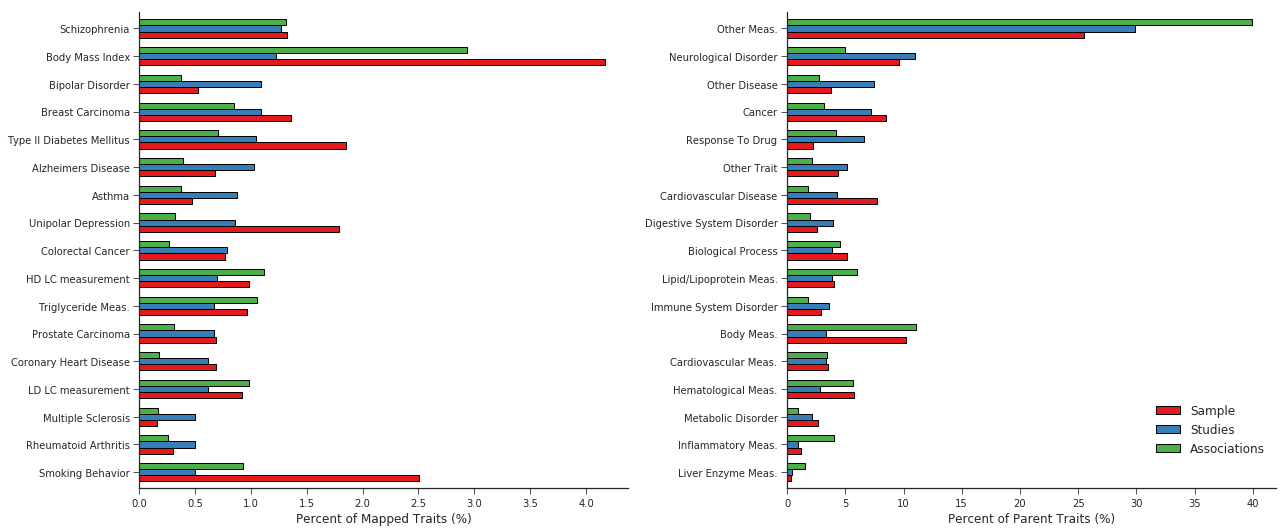

In [17]:
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'Helvetica'

MappedTrait_df_Count = EFO_Parent_Mapped.groupby('EFO term')['EFO term'].count(
).to_frame().rename(columns={'EFO term': 'Number of Studies'}).reset_index()
MappedTrait_df_AncSum = EFO_Parent_Mapped.groupby('EFO term')['N'].sum(
).to_frame().rename(columns={'N': 'Total Sample'}).reset_index()
MappedTrait_df_AssSum = EFO_Parent_Mapped.groupby(
    'EFO term')['ASSOCIATION COUNT'].sum().to_frame().rename(columns={
        'ASSOCIATION COUNT': 'Total Associations'}).reset_index()
MappedTrait_df_toplot = pd.merge(
    MappedTrait_df_AssSum, MappedTrait_df_AncSum, how='left', on='EFO term')
MappedTrait_df_toplot = pd.merge(
    MappedTrait_df_toplot, MappedTrait_df_Count, how='left', on='EFO term')
MappedTrait_df_toplot['Studies'] = (
    MappedTrait_df_toplot['Number of Studies'] /
    MappedTrait_df_toplot['Number of Studies'].sum()) * 100
MappedTrait_df_toplot['Associations'] = (
    MappedTrait_df_toplot['Total Associations'] /
    MappedTrait_df_toplot['Total Associations'].sum()) * 100
MappedTrait_df_toplot['Sample'] = (
    MappedTrait_df_toplot['Total Sample'] /
    MappedTrait_df_toplot['Total Sample'].sum()) * 100
MappedTrait_df_toplot = MappedTrait_df_toplot.set_index('EFO term')
MappedTrait_df_toplot = MappedTrait_df_toplot.sort_values(
    by='Studies', ascending=False)[0:17]
MappedTrait_df_toplot = MappedTrait_df_toplot[[
    'Sample', 'Studies', 'Associations']]

EFOParent_df_Count = EFO_Parent_Mapped.groupby(
    'Parent term')['Parent term'].count(
).to_frame().rename(columns={'Parent term': 'Number of Studies'}).reset_index()
EFOParent_df_AncSum = EFO_Parent_Mapped.groupby('Parent term')['N'].sum(
).to_frame().rename(columns={'N': 'Total Sample'}).reset_index()
EFOParent_df_AssSum = EFO_Parent_Mapped.groupby(
    'Parent term')['ASSOCIATION COUNT'].sum().to_frame().rename(
    columns={'ASSOCIATION COUNT': 'Total Associations'}).reset_index()
EFOParent_df_toplot = pd.merge(
    EFOParent_df_AssSum, EFOParent_df_AncSum, how='left', on='Parent term')
EFOParent_df_toplot = pd.merge(
    EFOParent_df_toplot, EFOParent_df_Count, how='left', on='Parent term')
EFOParent_df_toplot['Studies'] = (
    EFOParent_df_toplot['Number of Studies'] /
    EFOParent_df_toplot['Number of Studies'].sum()) * 100
EFOParent_df_toplot['Associations'] = (
    EFOParent_df_toplot['Total Associations'] /
    EFOParent_df_toplot['Total Associations'].sum()) * 100
EFOParent_df_toplot['Sample'] = (
    EFOParent_df_toplot['Total Sample'] /
    EFOParent_df_toplot['Total Sample'].sum()) * 100
EFOParent_df_toplot = EFOParent_df_toplot.set_index('Parent term')
EFOParent_df_toplot = EFOParent_df_toplot.sort_values(
    by='Studies', ascending=False)
EFOParent_df_toplot = EFOParent_df_toplot[[
    'Sample', 'Studies', 'Associations']]

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 7.5))
fig_a = MappedTrait_df_toplot.sort_values(by='Studies', ascending=True).plot(
    kind='barh', ax=axes[0], legend=False, colors=['#e41a1c','#377eb8',
                                                   '#4daf4a'], edgecolor='k',
    width=0.66)
fig_a.set_ylabel('')
fig_a.set_xlabel('Percent of Mapped Traits (%)', fontsize=12)
fig_b = EFOParent_df_toplot.sort_values(by='Studies', ascending=True).plot(
    kind='barh', ax=axes[1], legend=True, colors=['#e41a1c','#377eb8',
                                                  '#4daf4a'],
    edgecolor='k', width=0.66)
fig_b.set_ylabel('')
fig_b.set_xlabel('Percent of Parent Traits (%)', fontsize=12)
fig_b.legend(prop={'size': 12}, frameon=False,
             loc='bottom right', bbox_to_anchor=(1, 0.2), edgecolor='k')
plt.tight_layout()
sns.despine()

# Who funds GWAS and what do they fund?

## A simple descriptive tabulation

Lets do a super simple tabulation of the Top 20 GWAS funders (measured by 'GWAS contributions': i.e. a funder funding an authors time on a paper).

In [18]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
AllFunders = FunderInfo.groupby(by='Agency').count()
AllFunders.index.name = None
AllFunders = AllFunders.reset_index()
AllFunders = AllFunders.rename(columns={
                               'index': 'Agency',
                               'PUBMEDID': 'Grant Contributions',
                               'GrantCountry': 'Country'})
AllFunders_withcountries = pd.merge(AllFunders[['Agency',
                                                'Grant Contributions']],
                                    FunderInfo[['Agency',
                                                'GrantCountry']].drop_duplicates(
                                        'Agency'),
                                    on='Agency', how='left')
AllFunders_withcountries = AllFunders_withcountries.set_index('Agency')
AllFunders_withcountries.index.name = None
AllFunders_withcountries['% of Total'] = round((
    AllFunders_withcountries['Grant Contributions'] /
    AllFunders_withcountries['Grant Contributions'].sum()) * 100, 2)
AllFunders_withcountries.sort_values(
    'Grant Contributions', ascending=False)[0:20]

Grant Contributions    GrantCountry  % of Total
NHLBI NIH HHS                     12388   United States       27.23
NCI NIH HHS                        5013   United States       11.02
NIA NIH HHS                        3872   United States        8.51
MRC                                2913  United Kingdom        6.40
NIMH NIH HHS                       2593   United States        5.70
NIDDK NIH HHS                      2470   United States        5.43
NHGRI NIH HHS                      1718   United States        3.78
Wellcome Trust                     1608  United Kingdom        3.53
NCRR NIH HHS                       1527   United States        3.36
PHS HHS                            1137   United States        2.50
NIAID NIH HHS                      1028   United States        2.26
NIAMS NIH HHS                       938   United States        2.06
NIAAA NIH HHS                       886   United States        1.95
NINDS NIH HHS                       723   United States        1.59
NIDA NIH HHS                        682   United States        1.50
NCATS NIH HHS                       594   United States        1.31
Intramural NIH HHS                  573   United States        1.26
Cancer Research UK                  564  United Kingdom        1.24
NIGMS NIH HHS                       547   United States        1.20
NEI NIH HHS                         434   United States        0.95

Lets print out some simple descriptives from this data:

In [19]:
print('There are ' + str(len(FunderInfo['Agency'].drop_duplicates())) +
      ' unique funders returned from PubMed Central.')
print('There are ' + str(len(FunderInfo['GrantID'].drop_duplicates())) +
      ' unique grants returned from PubMed Central.')
print('There are ' + str(len(FunderInfo['GrantCountry'].drop_duplicates())) +
      ' unique grant countries returned from PubMed Central.')
print('Each study has an average of ' +
      str(round(len(FunderInfo) / len(id_list), 2)) + ' grants funding it.')
grantgroupby = FunderInfo.groupby(['Agency', 'GrantID']).size().groupby(
    level=1).max().sort_values(ascending=False).reset_index()
print('The most frequently acknowledged grant is GrantID ' +
      grantgroupby['GrantID'][0] + '.\nThis grant is acknowledged ' +
      str(grantgroupby[0][0]) + ' times.')

There are 87 unique funders returned from PubMed Central.
There are 12167 unique grants returned from PubMed Central.
There are 7 unique grant countries returned from PubMed Central.
Each study has an average of 13.73 grants funding it.
The most frequently acknowledged grant is GrantID P30 DK063491.
This grant is acknowledged 182 times.


## International distribution of funders

From which countries do these grants come from?

In [20]:
TopCountryFunders = FunderInfo.groupby(by='GrantCountry').count()
TopCountryFunders = TopCountryFunders.rename(
    columns={'PUBMEDID': 'Number Of Studies'})
TopCountryFunders = TopCountryFunders.sort_values(
    'Number Of Studies', ascending=False)[['Number Of Studies']]
TopCountryFunders = TopCountryFunders.reset_index().rename(
    columns={'GrantCountry': 'Country of Funder'})
TopCountryFunders['Percent Funded (%)'] = (
    TopCountryFunders['Number Of Studies'] /
    TopCountryFunders['Number Of Studies'].sum()) * 100
TopCountryFunders = TopCountryFunders.set_index('Country of Funder')
TopCountryFunders.index.name = None
TopCountryFunders.head(10)

Number Of Studies  Percent Funded (%)
United States               39273           86.316183
United Kingdom               6006           13.200290
Canada                        165            0.362645
International                  38            0.083518
Austria                         6            0.013187
None                            6            0.013187
Italy                           5            0.010989

## What do they fund?

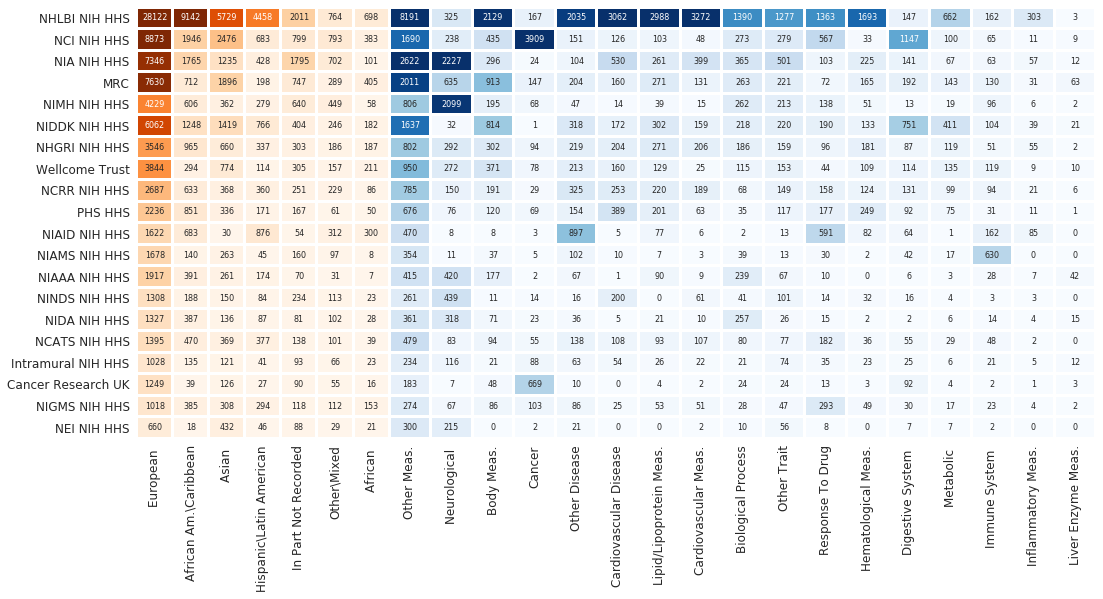

In [21]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
EFO_Parent_Mapped, EFO_Parent_Mapped_NoCommas = EFO_parent_mapper(
    Cat_Studies, Cat_Ancestry_groupedbyN)

EFO_Parent_Mapped['Parent term'] = \
    EFO_Parent_Mapped['Parent term'].str.replace('Disorder', '')

FunderInfo_Parent = pd.merge(FunderInfo, EFO_Parent_Mapped,
                             left_on='PUBMEDID', right_on='PUBMEDID',
                             how='left')

funder_parent = pd.DataFrame(
    index=FunderInfo.groupby(
        ['Agency'])['Agency'].count().sort_values(ascending=False).
    index.values[0:20].tolist(),
    columns=FunderInfo_Parent.groupby(['Parent term'])['Parent term'].count().
    sort_values(ascending=False).index.values.tolist())

for parent in FunderInfo_Parent.groupby(['Parent term'])['Parent term'].count().\
        sort_values(ascending=False).index.values.tolist():
    for funder in FunderInfo.groupby(['Agency'])['Agency'].count().sort_values(
            ascending=False).index.values[0:20].tolist():
        funder_parent[parent][funder] = len(
            FunderInfo_Parent[(FunderInfo_Parent['Agency'] == funder) & (
                FunderInfo_Parent['Parent term'] == parent)])
FunderInfo_Ancestry = pd.merge(FunderInfo, Cat_Ancestry, left_on='PUBMEDID',
                               right_on='PUBMEDID', how='left')

funder_ancestry = pd.DataFrame(index=FunderInfo.groupby(
    ['Agency'])['Agency'].count().sort_values(ascending=False).
    index.values[0:20].tolist(),
    columns=FunderInfo_Ancestry.groupby(
    ['Broader'])['Broader'].count().
    sort_values(ascending=False).index.values.tolist())

for ancestry in FunderInfo_Ancestry.groupby(
    ['Broader'])['Broader'].count().\
        sort_values(ascending=False).index.values.tolist():
    for funder in FunderInfo.groupby(['Agency'])['Agency'].count().sort_values(
            ascending=False).index.values[0:20].tolist():
        funder_ancestry[ancestry][funder] = len(
            FunderInfo_Ancestry[(FunderInfo_Ancestry['Agency'] == funder) & (
                FunderInfo_Ancestry['Broader'] == ancestry)])

sns.set(font_scale=8, font='Helvetica', style='white')
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False,
                             sharey=True, figsize=(18, 11),
                             gridspec_kw={'width_ratios': [.25, .7],
                                          'wspace': 0, 'hspace': 0})

gg = sns.heatmap(funder_ancestry.astype(float), ax=ax1, fmt='.0f',
                 annot=True,  cmap='Oranges', xticklabels=True,
                 yticklabels=True, linewidth=2, robust=True, cbar=False,
                 annot_kws={'size': 8})
gg.tick_params(axis='both', which='major', labelsize=12)
hh = sns.heatmap(funder_parent.astype(float), ax=ax2, fmt='.0f',
                 annot=True, cmap='Blues', xticklabels=True,
                 yticklabels=True, linewidth=2, robust=True,
                 cbar=False, annot_kws={'size': 8})
hh.tick_params(axis='both', which='major', labelsize=12)

plt.gcf()
plt.setp(ax2.get_yticklabels(), visible=False)
plt.tight_layout()
plt.savefig(os.path.abspath(os.path.join('__file__', '../..', 'Figures',
                                         'svg', 'Funder_Heatmap.svg')),
            bbox_inches='tight')
plt.savefig(os.path.abspath(os.path.join('__file__', '../..', 'Figures',
                                         'pdf', 'Funder_Heatmap.pdf')),
            bbox_inches='tight')
sns.set(font_scale=1, font='Helvetica')


# Who are the Authors?

Who are the most cited authors? What is their 'GWAS H-Index' calculated based only on their papers in the GWAS catalogue? This assumes unique forename + surname combinations, and that the same author is recorded consistently across studies. First a couple of snippets:

In [22]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
print('There are a total of ' + str(len(AuthorMaster)) +
      ' "authorship contributions".')
print('These contributions are made by ' +
      str(len(AuthorMaster['AUTHORNAME'].unique())) + ' unique authors.')
print('There are a total of ' +
      str(len(AuthorMaster) /
          len(AuthorMaster['PUBMEDID'].drop_duplicates())) +
      ' "authorship contributions per paper".')
print('The study with the most number of authors has ' +
      str(AuthorMaster.groupby(['PUBMEDID']).size().max()) +
      ' authors (PubMed ID: ' +
      str(AuthorMaster.groupby(['PUBMEDID']).size().idxmax()) + ')')

There are a total of 110659 "authorship contributions".
These contributions are made by 37053 unique authors.
There are a total of 33.553365676167374 "authorship contributions per paper".
The study with the most number of authors has 559 authors (PubMed ID: 22479202)


## Calculate 'GWAS-H' indexes

Lets then calculate our GWAS-H indexes using citation data and paper counts for unique authors.

In [23]:
CitationCounts = pd.read_csv(os.path.abspath(
    os.path.join('__file__', "../..",
                 "Data", "PUBMED", 'Pubmed_Cites.csv')))
AuthorMaster_withcites = pd.merge(
    AuthorMaster, CitationCounts, on=['PUBMEDID'], how='left')
allauthors_formerge = pd.DataFrame(
    AuthorMaster_withcites[['AUTHORNAME', 'citedByCount']])
allauthors_papercount = pd.DataFrame(
    allauthors_formerge['AUTHORNAME'].value_counts())
allauthors_citecount = pd.DataFrame(
    allauthors_formerge.groupby(by='AUTHORNAME')['citedByCount'].sum())
allauthors_merged = pd.merge(
    allauthors_papercount, allauthors_citecount, left_index=True,
    right_index=True)
allauthors_merged.columns = ['Papers', 'citedByCount']
allauthors_merged = allauthors_merged.sort_values(
    by='citedByCount', ascending=False)
allauthors_merged['GWAS-H'] = np.NaN
counter = 0
for author in allauthors_merged.index:
    counter += 1
    temp = AuthorMaster_withcites[AuthorMaster_withcites['AUTHORNAME'] ==
                                  author].sort_values(by='citedByCount',
                                                      ascending=False).dropna()
    temp = temp.reset_index()
    temp = temp.drop('index', 1)
    for pubnumber in range(0, len(temp)):
        if pubnumber + 1 > temp['citedByCount'][pubnumber]:
            # allauthors_merged['GWAS-H'][author]=pubnumber+1
            allauthors_merged.loc[author, ('GWAS-H')] = pubnumber + 1
            break
    sys.stdout.write('\r' + 'Calculating GWAS H-indices: finished ' +
                     str(counter) + ' of ' +
                     str(len(allauthors_merged.index)) + ' authors...')
allauthors_citecount.reset_index(inplace=True)
allauthors_papercount.reset_index(inplace=True)
allauthors_papercount.rename(
    columns={'AUTHORNAME': 'PAPERCOUNT', 'index': 'AUTHORNAME', },
    inplace=True)


Calculating GWAS H-indices: finished 37053 of 37053 authors...

## Calculate author centralities

Lets next calculate some measures of authorship centrality with Network-X. Note: this can take some time on slow computers. To get it to run faster, change the CitedByCount to be something like 100 to filter for authors with a minimum of a hundred citations only (or change PAPERCOUNT>1)

In [24]:
AuthorMaster_sumcites = pd.merge(AuthorMaster, allauthors_citecount,
                                 left_on='AUTHORNAME', right_on='AUTHORNAME',
                                 how='left')
AuthorMaster_sumcitespapercount = pd.merge(AuthorMaster_sumcites,
                                           allauthors_papercount,
                                           left_on='AUTHORNAME',
                                           right_on='AUTHORNAME', how='left')
AuthorMaster_sumcitespapercount_filter_cites = AuthorMaster_sumcitespapercount[
    AuthorMaster_sumcitespapercount['citedByCount'] > 10]
AuthorMaster_sumcitespapercount_filtered =\
    AuthorMaster_sumcitespapercount_filter_cites[
        AuthorMaster_sumcitespapercount_filter_cites['PAPERCOUNT'] > 1]

G = nx.Graph()
counter = 0
alledges = []
for paper in AuthorMaster_sumcitespapercount_filtered['PUBMEDID'].unique():
    counter += 1
    temp = AuthorMaster_sumcitespapercount_filtered[
        AuthorMaster_sumcitespapercount_filtered['PUBMEDID'] == paper]
    if len(temp) > 1:
        templist = list(itertools.combinations(temp.AUTHORNAME, 2))
        for edge in templist:
            alledges.append(edge)
G.add_edges_from(list(set(alledges)))

print('This gives us a network with ' + str(len(G)) +
      ' nodes.\nThese are unique authors with >1 paper and >10 cites')

betcent = pd.Series(nx.betweenness_centrality(G), name='Betweenness')
allauthors_merged = allauthors_merged.merge(
    betcent.to_frame(), left_index=True, right_index=True)

degcent = pd.Series(nx.degree_centrality(G), name='Degree')
allauthors_merged = allauthors_merged.merge(
    degcent.to_frame(), left_index=True, right_index=True)

This gives us a network with 13677 nodes.
These are unique authors with >1 paper and >10 cites


We can then merge all this data with some data collected manually from web searches related to their country of employment, their current employer, etc. We then rank in three different ways to analyze overlap between the three metrics.

In [25]:
authorsupplemental = pd.read_csv(os.path.abspath(
    os.path.join('__file__', "../..",
                 "Data", "Support", 'Author_Supplmentary.csv')),
     encoding='latin-1', index_col=0)
allauthors_merged_withsupp = pd.merge(allauthors_merged,
                                      authorsupplemental,
                                      left_index=True, right_index=True,
                                      how='left',)
allauthors_merged_withsupp.sort_values(by='GWAS-H',
                                       ascending=False).to_csv(
    os.path.abspath(os.path.join('__file__',
                                 "../..",
                                 "Tables", "Authors.csv")))
allauthors_merged_withsupp.sort_values(by='GWAS-H', ascending=False).head(20)

Papers  citedByCount  GWAS-H  Betweenness    Degree  \
Kari Stefansson            165         24434    81.0     0.021523  0.310910   
Unnur Thorsteinsdottir     132         21063    74.0     0.006670  0.245905   
Andre G Uitterlinden       257         19893    72.0     0.017325  0.353027   
Albert Hofman              255         21988    72.0     0.013629  0.342059   
Cornelia M van Duijn       175         17795    67.0     0.007957  0.283709   
Christian Gieger           155         19353    66.0     0.011867  0.274349   
H-Erich Wichmann           109         18395    66.0     0.008874  0.232524   
Gudmar Thorleifsson        112         18084    66.0     0.006514  0.235303   
Panos Deloukas              96         16812    62.0     0.007374  0.229087   
Fernando Rivadeneira       184         15537    62.0     0.008054  0.276543   
Mark I McCarthy             91         18402    61.0     0.003098  0.188944   
Leena Peltonen              73         15275    58.0     0.002442  0.161524   
Eric Boerwinkle            132         15073    57.0     0.002679  0.208321   
Marjo-Riitta Jarvelin       98         15153    57.0     0.002715  0.210661   
Jerome I Rotter            169         15660    56.0     0.010372  0.261480   
Tamara B Harris            123         12668    55.0     0.002459  0.233402   
Bruce M Psaty              153         11218    55.0     0.004560  0.242688   
Nicholas G Martin          150         11578    55.0     0.009811  0.268792   
Thomas Illig                84         14219    55.0     0.002402  0.179219   
Vilmundur Gudnason         119         12999    55.0     0.002939  0.242761   

                            Country               Institution  
Kari Stefansson             Iceland           deCode Genetics  
Unnur Thorsteinsdottir      Iceland           deCode Genetics  
Andre G Uitterlinden    Netherlands                Erasmus MC  
Albert Hofman                  U.S.     University of Harvard  
Cornelia M van Duijn    Netherlands             UMC Rotterdam  
Christian Gieger            Germany        Helmholtz-Muenchen  
H-Erich Wichmann            Germany        Helmholtz-Muenchen  
Gudmar Thorleifsson         Iceland           deCode Genetics  
Panos Deloukas                 U.K.            Queen Mary UoL  
Fernando Rivadeneira    Netherlands             UMC Rotterdam  
Mark I McCarthy                U.K.      University of Oxford  
Leena Peltonen                  NaN                       NaN  
Eric Boerwinkle                U.S.       University of Texas  
Marjo-Riitta Jarvelin          U.K.          Imperial College  
Jerome I Rotter                U.S.                      UCLA  
Tamara B Harris                U.S.                    N.I.H.  
Bruce M Psaty                  U.S.  University of Washington  
Nicholas G Martin         Australia            QIMR Berghofer  
Thomas Illig                Germany   Hannover Medical School  
Vilmundur Gudnason              NaN                       NaN

In [26]:
allauthors_merged_withsupp.sort_values(by='Degree',ascending=False).head(10)

Papers  citedByCount  GWAS-H  Betweenness    Degree  \
Andre G Uitterlinden       257         19893    72.0     0.017325  0.353027   
Albert Hofman              255         21988    72.0     0.013629  0.342059   
Kari Stefansson            165         24434    81.0     0.021523  0.310910   
Cornelia M van Duijn       175         17795    67.0     0.007957  0.283709   
Fernando Rivadeneira       184         15537    62.0     0.008054  0.276543   
Christian Gieger           155         19353    66.0     0.011867  0.274349   
Nicholas G Martin          150         11578    55.0     0.009811  0.268792   
Grant W Montgomery         144         11798    53.0     0.008961  0.263235   
Jerome I Rotter            169         15660    56.0     0.010372  0.261480   
Unnur Thorsteinsdottir     132         21063    74.0     0.006670  0.245905   

                            Country               Institution  
Andre G Uitterlinden    Netherlands                Erasmus MC  
Albert Hofman                  U.S.     University of Harvard  
Kari Stefansson             Iceland           deCode Genetics  
Cornelia M van Duijn    Netherlands             UMC Rotterdam  
Fernando Rivadeneira    Netherlands             UMC Rotterdam  
Christian Gieger            Germany        Helmholtz-Muenchen  
Nicholas G Martin         Australia            QIMR Berghofer  
Grant W Montgomery        Australia  University of Queensland  
Jerome I Rotter                U.S.                      UCLA  
Unnur Thorsteinsdottir      Iceland           deCode Genetics

In [27]:
allauthors_merged_withsupp.sort_values(by='citedByCount',
                                       ascending=False).head(10)

Papers  citedByCount  GWAS-H  Betweenness    Degree  \
Kari Stefansson            165         24434    81.0     0.021523  0.310910   
Albert Hofman              255         21988    72.0     0.013629  0.342059   
Unnur Thorsteinsdottir     132         21063    74.0     0.006670  0.245905   
Andre G Uitterlinden       257         19893    72.0     0.017325  0.353027   
Christian Gieger           155         19353    66.0     0.011867  0.274349   
Mark I McCarthy             91         18402    61.0     0.003098  0.188944   
H-Erich Wichmann           109         18395    66.0     0.008874  0.232524   
Gudmar Thorleifsson        112         18084    66.0     0.006514  0.235303   
Cornelia M van Duijn       175         17795    67.0     0.007957  0.283709   
Goncalo R Abecasis          78         17131    53.0     0.002226  0.172419   

                            Country            Institution  
Kari Stefansson             Iceland        deCode Genetics  
Albert Hofman                  U.S.  University of Harvard  
Unnur Thorsteinsdottir      Iceland        deCode Genetics  
Andre G Uitterlinden    Netherlands             Erasmus MC  
Christian Gieger            Germany     Helmholtz-Muenchen  
Mark I McCarthy                U.K.   University of Oxford  
H-Erich Wichmann            Germany     Helmholtz-Muenchen  
Gudmar Thorleifsson         Iceland        deCode Genetics  
Cornelia M van Duijn    Netherlands          UMC Rotterdam  
Goncalo R Abecasis              NaN                    NaN

And then make a simple correlation matrix to check how highly related these metrics are:

In [28]:
allauthors_merged_withsupp[['citedByCount', 'GWAS-H',
                            'Betweenness', 'Degree', 'Papers']].corr()

citedByCount    GWAS-H  Betweenness    Degree    Papers
citedByCount      1.000000  0.912297     0.515436  0.818468  0.838380
GWAS-H            0.912297  1.000000     0.590831  0.885177  0.939867
Betweenness       0.515436  0.590831     1.000000  0.498503  0.656072
Degree            0.818468  0.885177     0.498503  1.000000  0.850162
Papers            0.838380  0.939867     0.656072  0.850162  1.000000

In [29]:
print('There are a total of ' +
      str(len(allauthors_merged_withsupp)) + ' authors in the table.')
print('The person with the highest G-WAS H-Index is: ' +
      allauthors_merged_withsupp['GWAS-H'].idxmax())
print('The person with the highest Degree is: ' +
      allauthors_merged_withsupp['Degree'].idxmax())
print('The person with the highest citedByCount is: ' +
      allauthors_merged_withsupp['citedByCount'].idxmax())
print('The person with the most number of Papers is: ' +
      allauthors_merged_withsupp['Papers'].idxmax())

There are a total of 13677 authors in the table.
The person with the highest G-WAS H-Index is: Kari Stefansson
The person with the highest Degree is: Andre G Uitterlinden
The person with the highest citedByCount is: Kari Stefansson
The person with the most number of Papers is: Andre G Uitterlinden


## Author gender

Lets consider the gender of each author by analyzing their forenames using the genderguesser library. We can directly compare our results to [this wonderful paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0066212). One of the key assumptions made here is to combine all 'mostly_' male and female names into their respective male/female categories.

In [30]:
gendet = gender.Detector()
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()

AuthorCounts = AuthorMaster.groupby(['PUBMEDID'])['AUTHORNAME'].count(
).to_frame().reset_index().rename(columns={"AUTHORNAME": "Author Count"})
AuthorMaster = pd.merge(AuthorMaster, AuthorCounts, how='left', on='PUBMEDID')
AuthorMaster['CleanForename'] = AuthorMaster['FORENAME'].map(
    lambda x: clean_names(x))
AuthorMaster['CleanGender'] = AuthorMaster['CleanForename'].map(
    lambda x: gendet.get_gender(x))
AuthorMaster['MaleFemale'] = AuthorMaster['CleanGender'].str.replace('mostly_',
                                                                     '')
AuthorMaster['isfemale'] = np.where(
    AuthorMaster['MaleFemale'] == 'female', 1, 0)
AuthorFirst = AuthorMaster[AuthorMaster['Author Count']
                           > 4].drop_duplicates(subset='PUBMEDID', keep='first')
AuthorLast = AuthorMaster[AuthorMaster['Author Count']
                          > 4].drop_duplicates(subset='PUBMEDID', keep='last')
AuthorUnique = AuthorMaster.drop_duplicates(subset='AUTHORNAME')

for gender_ in AuthorMaster['CleanGender'].unique():
    print(str(round((len(AuthorMaster[AuthorMaster['CleanGender'] == gender_]) /
                     len(AuthorMaster['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' authorship contributions in total')
    print(str(round((len(AuthorUnique[AuthorUnique['CleanGender'] == gender_]) /
                     len(AuthorUnique['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' authors contributions in total')
    print(str(round((len(AuthorFirst[AuthorFirst['CleanGender'] == gender_]) /
                     len(AuthorFirst['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' first authors in total')
    print(str(round((len(AuthorLast[AuthorLast['CleanGender'] == gender_]) /
                     len(AuthorFirst['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' last authors in total')

print('\nPercent of male author contributions: ' +
      str(round(len(AuthorMaster[AuthorMaster['MaleFemale'] == 'male']) /
                (len(AuthorMaster[(AuthorMaster['MaleFemale'] == 'male') |
                                  (AuthorMaster['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

print('Percent of unique male authors: ' +
      str(round(len(AuthorUnique[AuthorUnique['MaleFemale'] == 'male']) /
                (len(AuthorUnique[(AuthorUnique['MaleFemale'] == 'male') |
                                  (AuthorUnique['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

print('Percent of male first authors: ' +
      str(round(len(AuthorFirst[AuthorFirst['MaleFemale'] == 'male']) /
                (len(AuthorFirst[(AuthorFirst['MaleFemale'] == 'male') |
                                 (AuthorFirst['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

print('Percent of male last authors: ' +
      str(round(len(AuthorLast[AuthorLast['MaleFemale'] == 'male']) /
                (len(AuthorLast[(AuthorLast['MaleFemale'] == 'male') |
                                (AuthorLast['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

AuthorMaster_filtered = AuthorMaster[(AuthorMaster['MaleFemale'].str.contains(
    'male')) & (AuthorMaster['Author Count'] > 4)]
AuthorMaster_filtered_merged_bydisease = pd.merge(
    AuthorMaster_filtered, Cat_Studies[['PUBMEDID', 'DISEASE/TRAIT']],
    how='left', on='PUBMEDID')
AuthorMaster_filtered_merged_bymappedtrait = pd.merge(
    AuthorMaster_filtered, Cat_Studies[['PUBMEDID', 'MAPPED_TRAIT']],
    how='left', on='PUBMEDID')

meanfemales_bydisease = AuthorMaster_filtered_merged_bydisease.groupby(
    ['DISEASE/TRAIT'])['isfemale'].mean().to_frame()
numberofstudies_bydisease = Cat_Studies.groupby(
    ['DISEASE/TRAIT'])['DISEASE/TRAIT'].count().to_frame()
mergedgender_andcount_bydisease = pd.merge(
    numberofstudies_bydisease, meanfemales_bydisease, left_index=True,
    right_index=True)
mergedgender_andcount_bydisease = mergedgender_andcount_bydisease.sort_values(
    by='DISEASE/TRAIT', ascending=False)[0:10]
holdstring = 'Percent of authorships across 10 most commonly studied diseases:\n'
for index, row in mergedgender_andcount_bydisease.iterrows():
    holdstring = holdstring + \
        index.title() + ' (' + str(round(row['isfemale'], 3) * 100) + '%)\n'
print('\n' + holdstring[:-2])


26.0% female authorship contributions in total
25.12% female authors contributions in total
26.71% female first authors in total
19.21% female last authors in total
45.24% male authorship contributions in total
37.63% male authors contributions in total
35.3% male first authors in total
48.9% male last authors in total
4.49% andy authorship contributions in total
5.15% andy authors contributions in total
7.25% andy first authors in total
3.66% andy last authors in total
1.31% mostly_male authorship contributions in total
1.47% mostly_male authors contributions in total
1.27% mostly_male first authors in total
1.74% mostly_male last authors in total
21.58% unknown authorship contributions in total
29.14% unknown authors contributions in total
28.26% unknown first authors in total
24.7% unknown last authors in total
1.39% mostly_female authorship contributions in total
1.5% mostly_female authors contributions in total
1.21% mostly_female first authors in total
1.8% mostly_female last aut

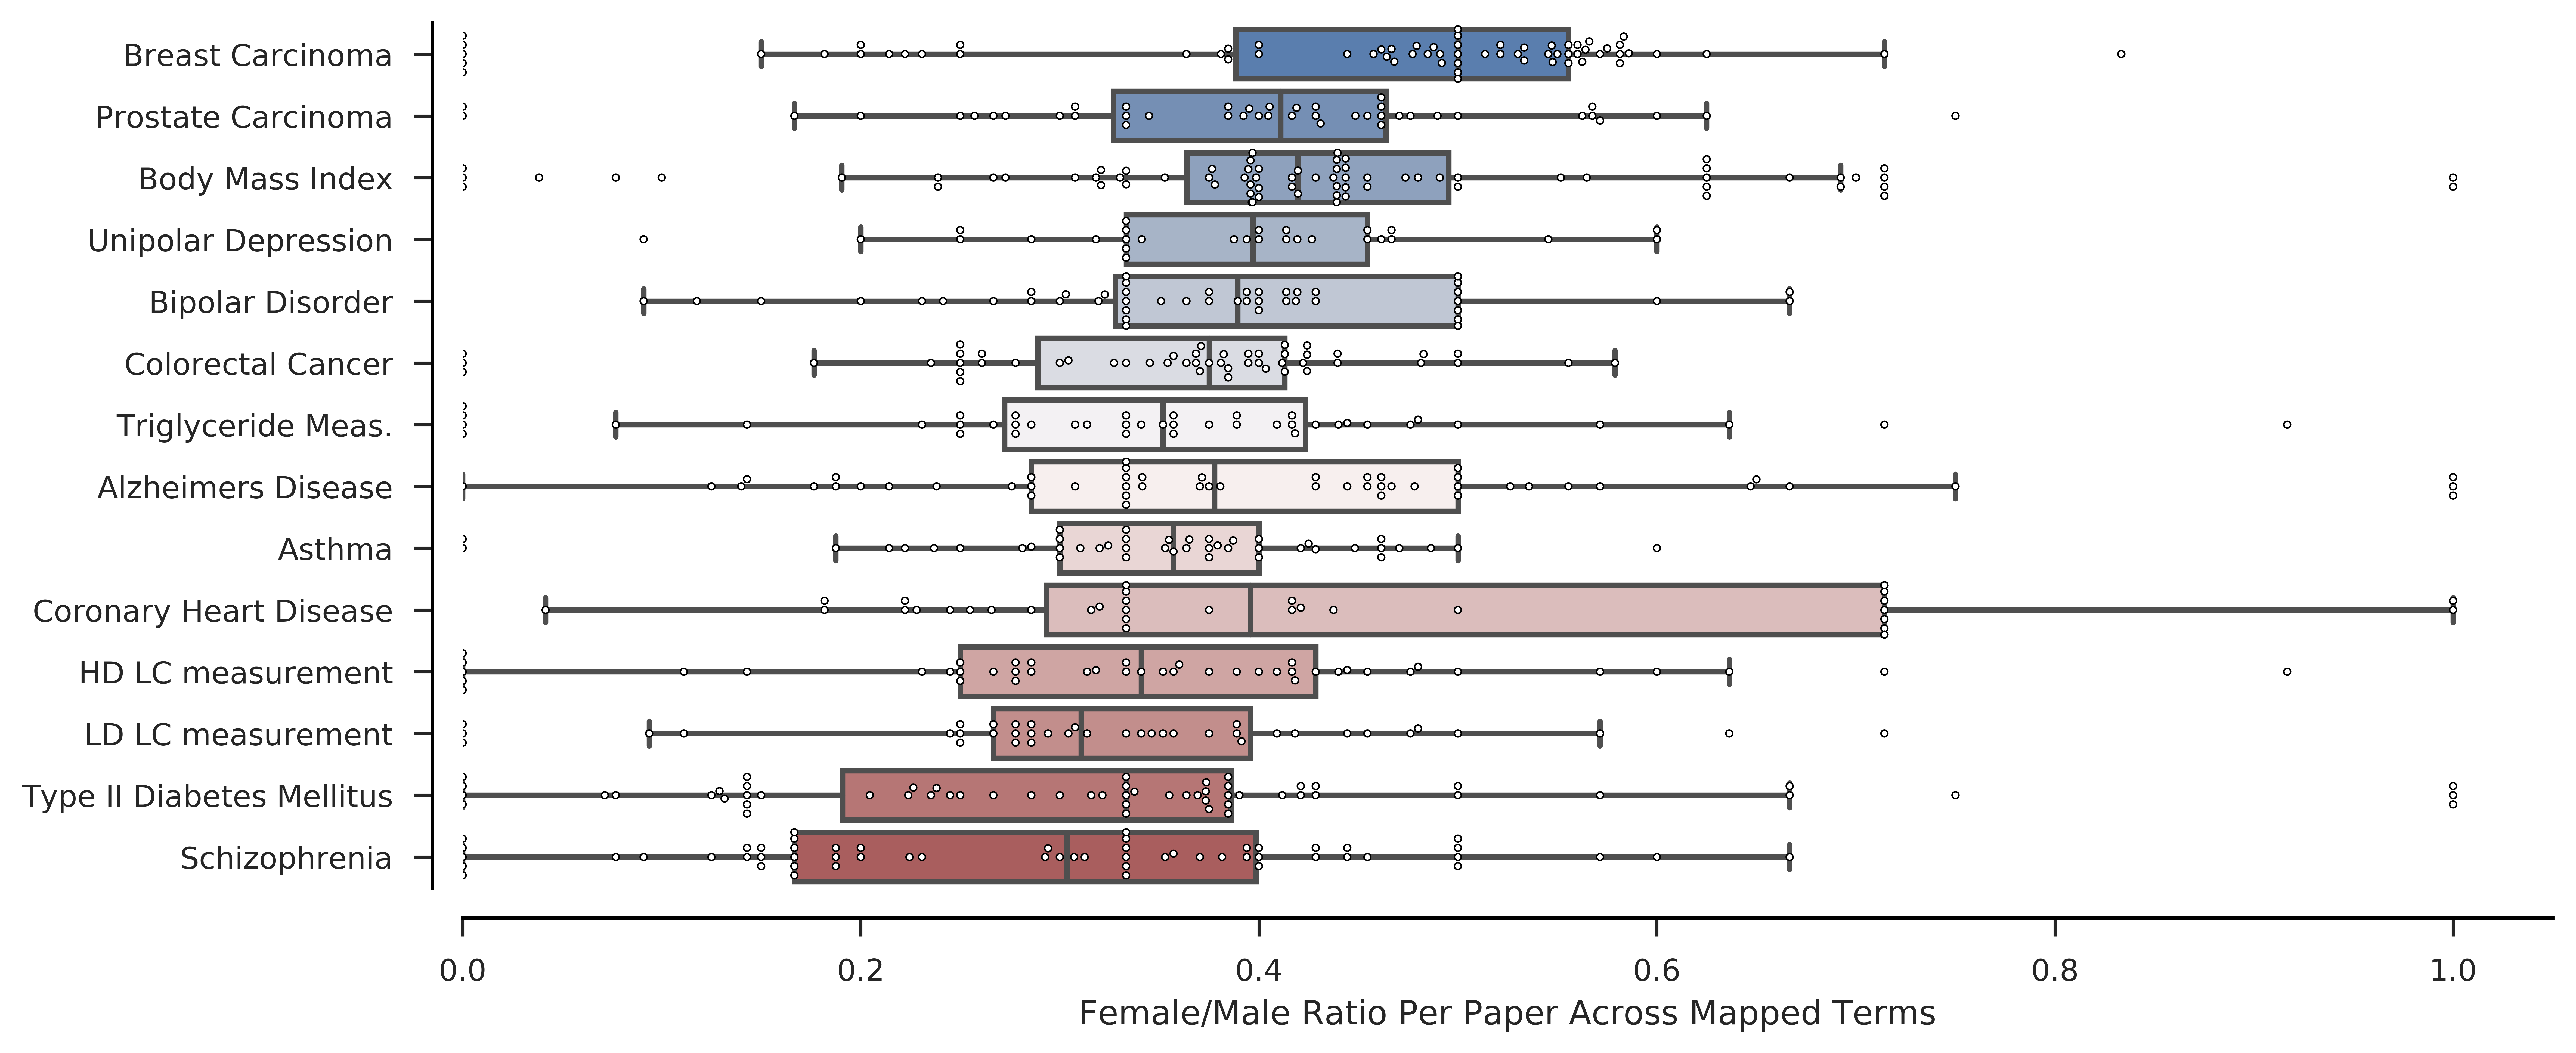

In [31]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
EFO_Parent_Mapped, EFO_Parent_Mapped_NoCommas = EFO_parent_mapper(
    Cat_Studies, Cat_Ancestry_groupedbyN)

AuthorMaster_merged = pd.merge(AuthorMaster[(
    AuthorMaster['MaleFemale'] == 'male') |
    (AuthorMaster['MaleFemale'] == 'female')],
    EFO_Parent_Mapped, how='left', on='PUBMEDID')

AuthorMaster_EFO = AuthorMaster_merged.groupby(
    ['EFO term'])['isfemale'].mean().to_frame()
AuthorMaster_Parent = AuthorMaster_merged.groupby(
    ['Parent term'])['isfemale'].mean().to_frame()

countstudiesperEFO = EFO_Parent_Mapped.groupby(['EFO term'])['PUBMEDID'].count(
).sort_values(ascending=False)[0:14].index.tolist()

meanfemalestudyaccession = AuthorMaster_merged.groupby(
    ['STUDY ACCESSION'])['isfemale'].mean().to_frame().reset_index()

meanfemalestudyaccession_withparent = pd.merge(EFO_Parent_Mapped[[
    'STUDY ACCESSION', 'Parent term']], meanfemalestudyaccession,
    on='STUDY ACCESSION', how='left')
meanfemalestudyaccession_withparent = meanfemalestudyaccession_withparent[
    ~meanfemalestudyaccession_withparent['isfemale'].isnull()]

meanfemalestudyaccession_withEFO = pd.merge(EFO_Parent_Mapped[[
    'STUDY ACCESSION', 'EFO term']], meanfemalestudyaccession,
    on='STUDY ACCESSION', how='left')
meanfemalestudyaccession_withEFO = meanfemalestudyaccession_withEFO[
    meanfemalestudyaccession_withEFO['EFO term'].isin(
        countstudiesperEFO)]
meanfemalestudyaccession_withEFO = meanfemalestudyaccession_withEFO[
    ~meanfemalestudyaccession_withEFO['isfemale'].isnull()]

AuthorMaster_EFO.reset_index(inplace=True)
ranks = AuthorMaster_EFO[AuthorMaster_EFO['EFO term'].isin(
    countstudiesperEFO)].sort_values(by='isfemale',
                                     ascending=False)['EFO term'].tolist()
sns.set(font="Helvetica", style='ticks')

fig = plt.figure(figsize=(12, 5), dpi=800)
ax1 = fig.add_subplot(1, 1, 1)

p = sns.boxplot(data=meanfemalestudyaccession_withEFO,
                y='EFO term', ax=ax1, order=ranks,
                x='isfemale', whis=1.5, palette="vlag", fliersize=0)
x = sns.swarmplot(y='EFO term', x='isfemale',
                  data=meanfemalestudyaccession_withEFO, order=ranks,
                  size=2.25, color="white", edgecolor="black", linewidth=0.5,
                  ax=ax1)
p.set_ylabel('')
p.set_xlim(0, 1.05)
p.set(axis_bgcolor='white')
p.set_xlabel('Female/Male Ratio Per Paper Across Mapped Terms')
plt.setp(p.spines.values(), color='k')
plt.setp([p.get_xticklines(), p.get_yticklines()], color='k')
sns.despine(bottom=False, left=False, offset=10, ax=ax1)

plt.tight_layout()
plt.savefig(os.path.abspath(os.path.join('__file__', "../..", "Figures",
                                         "svg", 'Gender_by_Subjects.svg')),
            bbox_inches='tight')
plt.savefig(os.path.abspath(os.path.join('__file__', "../..", "Figures",
                                         "pdf", 'Gender_by_Subjects.pdf')),
            bbox_inches='tight')

sns.set(font_scale=1, font="Helvetica")

In [32]:
AuthorMaster_Parent.reset_index(inplace=True)
holdstring = 'Get the numbers for Parent Terms:\n'
for index, row in AuthorMaster_Parent.iterrows():
    holdstring = holdstring + row['Parent term'].title() + ' (' \
        + str(round(row['isfemale'], 3) * 100) + '%)\n'
print('\n' + holdstring[:-2])

holdstring = 'Get the numbers for Trait Terms (figure above):\n'
for index, row in AuthorMaster_EFO[
    AuthorMaster_EFO['EFO term'].isin(countstudiesperEFO)].sort_values(
        by='isfemale', ascending=False).iterrows():
    holdstring = holdstring + \
        row['EFO term'].title() + ' (' + str(round(row['isfemale'], 3) *
                                             100) + '%)\n'
print('\n' + holdstring[:-2])


Get the numbers for Parent Terms:
Biological Process (41.199999999999996%)
Body Meas. (41.4%)
Cancer (47.3%)
Cardiovascular Disease (32.6%)
Cardiovascular Meas. (32.9%)
Digestive System Disorder (33.800000000000004%)
Hematological Meas. (34.300000000000004%)
Immune System Disorder (37.4%)
Inflammatory Meas. (34.0%)
Lipid/Lipoprotein Meas. (36.8%)
Liver Enzyme Meas. (37.2%)
Metabolic Disorder (33.800000000000004%)
Neurological Disorder (35.6%)
Other Disease (33.800000000000004%)
Other Meas. (38.5%)
Other Trait (35.6%)
Response To Drug (36.0%

Get the numbers for Trait Terms (figure above):
Breast Carcinoma (50.9%)
Prostate Carcinoma (41.8%)
Body Mass Index (41.099999999999994%)
Unipolar Depression (37.7%)
Bipolar Disorder (37.0%)
Colorectal Cancer (36.9%)
Triglyceride Meas. (36.7%)
Alzheimers Disease (36.7%)
Asthma (36.6%)
Coronary Heart Disease (36.4%)
Hd Lc Measurement (36.1%)
Ld Lc Measurement (34.8%)
Type Ii Diabetes Mellitus (32.1%)
Schizophrenia (31.0%


# Cohorts and Consortium

## Consortium/collectives

Lets use the PubMed database returns on collectives to analyze which consortium and study groups are acknowledged:

In [33]:
pubmed_collectives = pd.read_csv(os.path.abspath(
                                 os.path.join('__file__', '../..',
                                              'Data', 'PUBMED',
                                              'Pubmed_CollectiveInfo.csv')),
                                 encoding='latin-1')
collect_dict = pd.read_csv(os.path.abspath(
                           os.path.join(
                               '__file__', '../..', 'Data',
                               'Support', 'Collectives',
                               'Collective_Dictionary.csv')),
                           encoding='latin-1')
pubmed_collectives['COLLECTIVE'] = pubmed_collectives['COLLECTIVE'].str.strip()
pubmed_collectives['COLLECTIVE'] = pubmed_collectives['COLLECTIVE'].str.lower()
collect_dict['COLLECTIVE'] = collect_dict['COLLECTIVE'].str.strip(
).str.lower()
merged_collect = pd.merge(
    pubmed_collectives, collect_dict, how='left', on='COLLECTIVE')
if len(merged_collect[merged_collect['Clean_Name'].isnull()]) > 0:
    print('Danger! Correct collectives in Collective_Unverified.csv ' +
          'and add to the dictionary\n')
    unverified_collect = merged_collect[merged_collect['Clean_Name'].isnull(
    )]
    unverified_collect.to_csv(os.path.abspath(
                              os.path.join('__file__', '../..',
                                           'Data', 'Support', 'Collectives',
                                           'Collective_Unverified.csv')))
else:
    print('The consortium dictionary is up to date!\n')
consortiumlist = []
for index, row in merged_collect.iterrows():
    if pd.isnull(row['Clean_Name']) is False:
        for consortium in row['Clean_Name'].split(';'):
            consortiumlist.append(consortium)
clean_collectives = pd.DataFrame(consortiumlist, columns=['Consortium'])
groupby_collectives = clean_collectives.groupby(
    ['Consortium'])['Consortium'].count().sort_values(ascending=False)
holdstring = 'The most frequently seen Consortium are:\n'
for index, row in groupby_collectives.to_frame()[0:10].iterrows():
    holdstring = holdstring + index + ' (' + str(row['Consortium']) + ')\n'
print(holdstring[:-2] + '.')

print('\nWe have seen a total of ' +
      str(len(groupby_collectives.to_frame())) + ' different collectives!')
print('A total of ' + str(len(pubmed_collectives['PUBMEDID'].drop_duplicates(
))) + ' papers are contributed to by at least one collective.')
print('A total of ' + str(groupby_collectives.sum()) +
      ' collective contributions are made.')

The consortium dictionary is up to date!

The most frequently seen Consortium are:
Wellcome Trust Case Control Consortium (42)
CHARGE (38)
Wellcome Trust Case Control Consortium 2 (32)
DIAGRAM (28)
LifeLines Cohort Study (28)
Alzheimer's Disease Neuroimaging Initiative (25)
CARDIOGRAM (24)
MAGIC (19)
kConFab (16)
GIANT Consortium (16.

We have seen a total of 612 different collectives!
A total of 753 papers are contributed to by at least one collective.
A total of 1429 collective contributions are made.


## Datasets

Lets now simply wrangle together some of the manually collated data and consider the most frequently observed cohorts, with the aim being to analyze the resampling issue discussed earlier in the literature.

In [34]:
finaldataset = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'Data',
                 'Support', 'Cohorts',
                 'GWASCat1to1000 final.csv')),
    encoding='latin-1',
    index_col='Number')
mylist = []
for index, row in finaldataset.iterrows():
    mylist = mylist + row['DATASETS'].split(';')

mylist = [x.strip(' ') for x in mylist]
df1 = pd.DataFrame({'Cohorts': mylist})
reader = csv.reader(open(os.path.abspath(os.path.join(
    '__file__', '../..', 'Data', 'Support', 'Cohorts',
    'Dictionary_cohorts.csv')), 'r'))
d = {}
for row in reader:
    k, v = row
    d[k] = v
for key in d:
    df1['Cohorts'].replace(key, d[key], inplace=True)
df1['Cohorts'] = df1['Cohorts'].str.replace(
    'Rotterdam Study I (RS-I)', 'Rotterdam Study (RS)')
newdf = pd.DataFrame(df1.groupby(['Cohorts'])[
                     'Cohorts'].count(), columns=['Count'])

newdf = pd.DataFrame({'Count': df1.groupby(['Cohorts']).size()}).reset_index()

Then merge this with manually collated data:

In [35]:
manual_cohort_for_merge = pd.read_csv(os.path.abspath(
    os.path.join('__file__', "../..", "Data",
                 "Support", "Cohorts",
                 "manual_cohort_for_merge.csv")),
    encoding='latin-1', index_col=False)

merged_manual = pd.merge(newdf, manual_cohort_for_merge,
                         how='left', on='Cohorts')
merged_manual.set_index('Cohorts').sort_values(
    by='Count', ascending=False).drop('NO NAME').head(10).style


In [36]:
print('We guess there are a total of ' + str(len(newdf)) +
      ' different cohorts used in the 1000 biggest studies.')

We guess there are a total of 1852 different cohorts used in the 1000 biggest studies.


Lets now print out a list of the 50 most commonly used datasets in case we need to reference any specific particularily prominent ones (e.g. deCODE, UKBioBank etc):

In [37]:
merged_manual=merged_manual.set_index('Cohorts').sort_values(
    by='Count', ascending=False).drop('NO NAME')[['Count']]

holder='The twenty most commonly used datasets are:\n'
for index, row in merged_manual[0:50].iterrows():
    holder = holder + \
        str(index) + ' (' + str(row['Count']) + ' times)\n'
        
print(holder[:-2])

The twenty most commonly used datasets are:
Rotterdam Study (RS) (373 times)
Atherosclerosis Risk in Communities Study (ARIC) (187 times)
Framingham Heart Study (FHS) (183 times)
Cardiovascular Health Study (CHS) (163 times)
British 1958 Birth Cohort Study (B58C) (144 times)
Study of Health in Pomerania (SHIP) (120 times)
UK Adult Twin Register (TwinsUK) (120 times)
Nurses Health Study (NHS) (112 times)
Aging Gene-Environment Susceptibility - Reykjavik Study (AGES) (110 times)
European Prospective Investigation into Cancer (EPIC) (108 times)
Wellcome Trust Case Control Consortium (WTCCC) (103 times)
deCODE Genetics (deCODE) (101 times)
Erasmus Rucphen Family Study (ERF) (94 times)
Northern Finnish Birth Cohort Study (NFBC) (83 times)
Cooperative Health Research in the Region of Augsburg (KORA) (81 times)
Health, Aging, and Body Composition Study (Health ABC) (81 times)
Multi-Ethnic Study of Atherosclerosis (MESA) (79 times)
Netherlands Twin Registry (NTR) (74 times)
Lothian Birth Cohor